# **Data Exploration**

**Mục tiêu**:

- Hiểu cấu trúc dữ liệu: số dòng, số cột, danh sách và ý nghĩa các features.
- Đánh giá chất lượng dữ liệu: missing, invalid, cardinality, outliers.
- Phân tích phân phối của từng feature (numeric & categorical).
- Phân tích mối quan hệ giữa feature với nhau và với biến mục tiêu `target`.
- Rút ra các insight, đặt và trả lời một số câu hỏi để hiểu sâu về bộ dữ liệu.

## Import thư viện

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

from src.visualization import (
    plot_missing_bar,
    plot_outliers,
    plot_target_distribution,
    plot_numeric_distribution,
    plot_ecdf,
    plot_categorical_distribution,
    plot_pie,
    plot_target_rate_by_category,
    boxplot_numeric_by_target,
    plot_hist_overlay_by_target,
    plot_scatter,
    plot_scatter_matrix,
    plot_correlation_heatmap,
    visualize_q1_risk_profiles,
    visualize_q2_training_hours_effect,
    visualize_q3_exp_cdi_interaction,
    visualize_q4_career_trajectories,
    visualize_q5_missing_patterns,
    visualize_q6_risk_buckets,
)

# Để phục vụ phân tích thông kê
from src.data_processing import (
    string_column_to_float,
    detect_outliers_iqr,
)

# Để xem số liệu rõ ràng hơn
np.set_printoptions(suppress=True)

## I. Chuẩn bị dữ liệu & Thông tin tổng quan

**Ở phần này sẽ thực hiện các công việc sau:**

- Load file CSV vào NumPy.
- Tách header và data.
- In ra số dòng, số cột.
- Liệt kê danh sách các feature.

### Load dữ liệu

In [2]:
DATA_PATH = os.path.join(PROJECT_ROOT, "data", "raw", "aug_train.csv")

with open(DATA_PATH, "r", encoding="utf-8") as f:
    header = f.readline().strip().split(",")

data = np.genfromtxt(
    DATA_PATH,
    delimiter=",",
    dtype=str,
    skip_header=1
)

print("Xem thử 5 dòng đầu của bộ dữ liệu:")
for i in range(5):
    print(data[i])

Xem thử 5 dòng đầu của bộ dữ liệu:
['8949' 'city_103' '0.92' 'Male' 'Has relevent experience' 'no_enrollment'
 'Graduate' 'STEM' '>20' '' '' '1' '36' '1.0']
['29725' 'city_40' '0.7759999999999999' 'Male' 'No relevent experience'
 'no_enrollment' 'Graduate' 'STEM' '15' '50-99' 'Pvt Ltd' '>4' '47' '0.0']
['11561' 'city_21' '0.624' '' 'No relevent experience' 'Full time course'
 'Graduate' 'STEM' '5' '' '' 'never' '83' '0.0']
['33241' 'city_115' '0.789' '' 'No relevent experience' '' 'Graduate'
 'Business Degree' '<1' '' 'Pvt Ltd' 'never' '52' '1.0']
['666' 'city_162' '0.767' 'Male' 'Has relevent experience' 'no_enrollment'
 'Masters' 'STEM' '>20' '50-99' 'Funded Startup' '4' '8' '0.0']


### Thông tin tổng quan

In [3]:
num_rows, num_cols = data.shape

print(f"Số dòng (samples): {num_rows}")
print(f"Số cột (features): {num_cols}\n")

print("Danh sách features:")
for i, col in enumerate(header):
    print(f"{i:2d}. {col}")

Số dòng (samples): 19158
Số cột (features): 14

Danh sách features:
 0. enrollee_id
 1. city
 2. city_development_index
 3. gender
 4. relevent_experience
 5. enrolled_university
 6. education_level
 7. major_discipline
 8. experience
 9. company_size
10. company_type
11. last_new_job
12. training_hours
13. target


#### Ý nghĩa của các features
- **enrollee_id** — ID ứng viên (unique identifier).
- **city** — mã thành phố ứng viên sinh sống.
- **city_development_index** — mức độ phát triển của thành phố (0–1).
- **gender** — giới tính của ứng viên.
- **relevent_experience** — ứng viên có kinh nghiệm liên quan hay không.
- **enrolled_university** — ứng viên đang theo học loại chương trình đại học nào.
- **education_level** — trình độ học vấn cao nhất.
- **major_discipline** — chuyên ngành học.
- **experience** — số năm kinh nghiệm làm việc.
- **company_size** — quy mô công ty nơi ứng viên làm việc.
- **company_type** — loại hình doanh nghiệp.
- **last_new_job** — số năm kể từ công việc trước.
- **training_hours** — số giờ đào tạo đã hoàn thành.
- **target** — 1 nếu ứng viên muốn đổi việc; 0 nếu không.

## II. Tổng quan về các đặc trưng của bộ dữ liệu

**Phần này sẽ thực hiện các nhiệm vụ sau:**
- Kiểm tra duplicate rows cũng như duplicate IDs
- Ước lượng kiểu dữ liệu hiện tại cho từng cột: Numeric vs Categorical.
- Tính số lượng giá trị khác nhau cho từng cột.
- Đếm số lượng missing values ở từng cột.
- Vẽ biểu đồ bar cho missing values (`plot_missing_bar`).
- Kiểm tra sơ bộ các giá trị không hợp lệ:
  - Numeric nhưng chứa text kỳ lạ (vd: `'??'`, `'unknown'`).

### Helper functions

In [4]:
MISSING_TOKENS = {"", "nan", "NaN", "NULL", "null", "NA", "?"}

def is_missing(x: str) -> bool:
    if x is None:
        return True
    x = str(x).strip()
    return x == "" or x in MISSING_TOKENS

def is_float(x: str) -> bool:
    try:
        float(x)
        return True
    except:
        return False

col_idx_map = {name: idx for idx, name in enumerate(header)}

def get_col(col_name: str) -> np.ndarray:
    return data[:, col_idx_map[col_name]]

### Kiểm tra duplicate rows & duplicate IDs

In [5]:
# Duplicate rows
rows_str = np.array(["||".join(row) for row in data])
unique_rows, counts_rows = np.unique(rows_str, return_counts=True)
num_dup_rows = np.sum(counts_rows > 1)
print("Số lượng dòng trùng nhau:", num_dup_rows)

# Duplicate enrollee_id
if "enrollee_id" in header:
    enrollee_ids = get_col("enrollee_id")
    unique_ids, counts_ids = np.unique(enrollee_ids, return_counts=True)
    num_dup_ids = np.sum(counts_ids > 1)
    print("Số enrollee_id bị trùng:", num_dup_ids)

Số lượng dòng trùng nhau: 0
Số enrollee_id bị trùng: 0


### Nhận dạng kiểu dữ liệu
**Ý tưởng thực hiện như sau:**
1. **Lọc dữ liệu:** Với mỗi cột, loại bỏ các giá trị `null` để chỉ xét dữ liệu thực tế.
2. **Lấy mẫu ngẫu nhiên (Sampling):** Thay vì duyệt toàn bộ hàng nghìn dòng, chỉ lấy ra tối đa **50 mẫu** bất kỳ.
3. **Quy tắc quyết định (Decision Threshold):**
   - Kiểm tra xem từng giá trị trong mẫu có phải là số (`is_float`) hay không.
   - Nếu tỷ lệ các giá trị là số **> 55%** (cho phép lẫn một chút dữ liệu rác/nhiễu), cột đó được kết luận là **Numeric**.
   - Ngược lại, xếp loại là **Categorical**.

In [6]:
numeric_cols_raw = []
categorical_cols_raw = []
cardinality = {}

for j in range(num_cols):
    col_name = header[j]
    col_data = data[:, j]
    non_missing = np.array([x for x in col_data if not is_missing(x)])

    if len(non_missing) > 0:
        cardinality[col_name] = len(np.unique(non_missing))
    else:
        cardinality[col_name] = 0

    if len(non_missing) == 0:
        categorical_cols_raw.append(col_name)
        continue

    sample_size = min(50, len(non_missing))
    sample = np.random.choice(non_missing, size=sample_size, replace=False)
    numeric_ratio = np.mean([is_float(x) for x in sample])

    if numeric_ratio > 0.85:
        numeric_cols_raw.append(col_name)
    else:
        categorical_cols_raw.append(col_name)

max_len = max(len("Tên cột"), max(len(col) for col in header))

print("=" * (max_len + 20))
print(f"{'Tên cột'.ljust(max_len)} | Kiểu dữ liệu")
print("-" * (max_len + 20))

for col in numeric_cols_raw:
    print(f"{col.ljust(max_len)} | Numeric")

for col in categorical_cols_raw:
    print(f"{col.ljust(max_len)} | Categorical")

print("=" * (max_len + 20))

Tên cột                | Kiểu dữ liệu
------------------------------------------
enrollee_id            | Numeric
city_development_index | Numeric
training_hours         | Numeric
target                 | Numeric
city                   | Categorical
gender                 | Categorical
relevent_experience    | Categorical
enrolled_university    | Categorical
education_level        | Categorical
major_discipline       | Categorical
experience             | Categorical
company_size           | Categorical
company_type           | Categorical
last_new_job           | Categorical


#### **Nhận xét**

Kết hợp giữa kết quả tự động nhận diện kiểu dữ liệu và việc kiểm tra mẫu (sampling) thực tế, ta xác định kiểu dữ liệu từng feature để đưa ra phương pháp xử lý (Preprocessing) phù hợp nhất, cụ thể ở categorical:

**1. Biến Ordinal (Định tính có thứ tự):**
Các biến này mang ý nghĩa cấp bậc hoặc mức độ. Cần sử dụng **Ordinal Encoding** (gán nhãn số theo thứ tự) để mô hình hiểu được tính chất "lớn/nhỏ" của dữ liệu:

* **`education_level`**: Primary School, High School ...
* **`company_size`**: <10, 10-49, 50-99 ...
* **`relevent_experience`**: No relevent experience, Has relevent experience.
* **`last_new_job`**: never, 1 ...
* **`experience`**: <1, 1, 2, >20,...

**2. Biến Nominal (Định tính danh nghĩa/ngang hàng):**
Các biến này dùng để phân nhóm và không có thứ tự hơn kém. Cần sử dụng **One-Hot Encoding** (với số lượng nhóm nhỏ) để tránh làm mô hình hiểu sai về thứ tự:

* **`major_discipline`**: STEM, Arts, ...
* **`company_type`**: Pvt Ltd, Funded Startup, ...
* **`gender`**: Male, Female, Other.
* **`enrolled_university`**: no_enrollment, Part time course, Full time course. *(Tuy có thể coi là Ordinal theo cường độ học, nhưng xử lý như Nominal sẽ an toàn và khách quan hơn).*
* **`city`**: city_21, city_40 ...

### Số lượng các giá trị khác nhau (Unique value)

In [7]:
print("Số lượng các giá trị khác nhau cho từng feature (unique value):")
for name in header:
    print(f"{name:30s}: {cardinality[name]}")

Số lượng các giá trị khác nhau cho từng feature (unique value):
enrollee_id                   : 19158
city                          : 123
city_development_index        : 93
gender                        : 3
relevent_experience           : 2
enrolled_university           : 3
education_level               : 5
major_discipline              : 6
experience                    : 22
company_size                  : 8
company_type                  : 6
last_new_job                  : 6
training_hours                : 241
target                        : 2


#### **Nhận xét**

**1. Biến định danh (`enrollee_id`):**
* **Số lượng:** 19,158 (tương đương tổng số dòng dữ liệu).
* **Nhận xét:** Đây là mã định danh duy nhất (Unique ID), không mang ý nghĩa dự báo. Sẽ bị drop trong phần processing.

**2. Biến phân loại có độ phân giải cao (`city`):**
* **Số lượng:** 123 giá trị.
* **Nhận xét:** Đây là biến High Cardinality. Ta nên tránh dùng **One-Hot Encoding** vì sẽ tạo ra 123 cột mới (gây loãng dữ liệu/Curse of Dimensionality). Có thể sẽ dùng **Frequency Encoding** hoặc **Target Encoding**.

**3. Biến phân loại tiêu chuẩn (Low Cardinality):**
* **Nhóm:** `gender`, `company_size`, `education_level`... (đều < 10 giá trị).
* **Nhận xét:** Số lượng nhóm nhỏ, rất lý tưởng dùng **One-Hot Encoding** (với biến Nominal) hoặc **Ordinal Encoding** (với biến có thứ tự).

**4. Biến mục tiêu (`target`):**
* **Số lượng:** 2.
* **Nhận xét:** Đây là bài toán phân loại nhị phân (Binary Classification).

### Kiểm tra missing values

In [8]:
missing_counts = np.zeros(num_cols, dtype=int)

for j in range(num_cols):
    col_data = data[:, j]
    missing_counts[j] = np.sum([is_missing(x) for x in col_data])

missing_ratios = missing_counts / num_rows

col_width_name = max(max(len(name) for name in header), len("Feature"))
col_width_cnt = max(max(len(str(c)) for c in missing_counts), len("Missing"))
col_width_ratio = len("Ratio")

print("=" * (col_width_name + col_width_cnt + col_width_ratio + 10))
print(f"{'Feature'.ljust(col_width_name)} | "
      f"{'Missing'.rjust(col_width_cnt)} | "
      f"{'Ratio'}")
print("-" * (col_width_name + col_width_cnt + col_width_ratio + 10))

for name, cnt, ratio in zip(header, missing_counts, missing_ratios):
    print(f"{name.ljust(col_width_name)} | "
          f"{str(cnt).rjust(col_width_cnt)} | "
          f"{ratio:6.3f}")

print("=" * (col_width_name + col_width_cnt + col_width_ratio + 10))

Feature                | Missing | Ratio
--------------------------------------------
enrollee_id            |       0 |  0.000
city                   |       0 |  0.000
city_development_index |       0 |  0.000
gender                 |    4508 |  0.235
relevent_experience    |       0 |  0.000
enrolled_university    |     386 |  0.020
education_level        |     460 |  0.024
major_discipline       |    2813 |  0.147
experience             |      65 |  0.003
company_size           |    5938 |  0.310
company_type           |    6140 |  0.320
last_new_job           |     423 |  0.022
training_hours         |       0 |  0.000
target                 |       0 |  0.000


#### Bar chart


Thống kê missing values:
enrollee_id               :      0
city                      :      0
city_development_index    :      0
gender                    :   4508
relevent_experience       :      0
enrolled_university       :    386
education_level           :    460
major_discipline          :   2813
experience                :     65
company_size              :   5938
company_type              :   6140
last_new_job              :    423
training_hours            :      0
target                    :      0
Tổng số missing: 20733



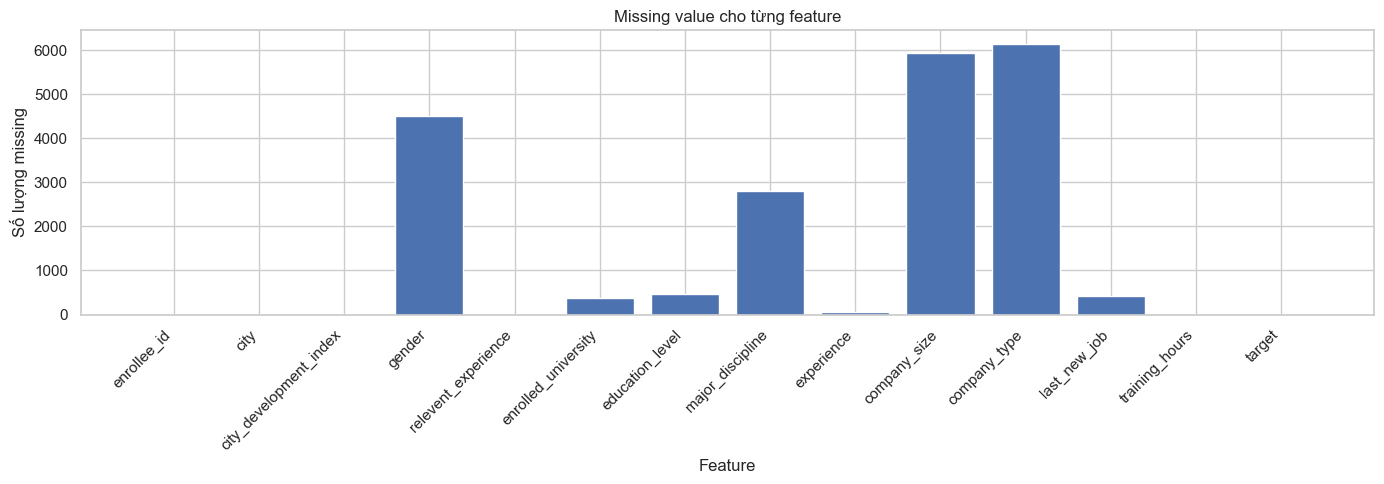

In [9]:
plot_missing_bar(header, missing_counts)

#### **Nhận xét**
Nhìn vào biểu đồ và số liệu thống kê, ta có thể thấy được số lượng missing khá lớn. Nhưng nhìn về mặt thực tế thì điều này là hoàn toàn bình thường. Cụ thể:

* **`company_size` & `company_type` (Thiếu nhiều nhất):** Lí do bị missing nhiều là vì ứng viên đó mới vừa ra trường chưa có việc hoặc có thể do đang thất nghiệp và mong muốn tìm công việc mới thông qua training này.
* **`gender` (thiếu khá nhiều):** Do ứng viên muốn giữ **quyền riêng tư** không muốn bị lộ giới tính. Điều này hoàn toàn bình thường.
* **`major_discipline` (thiếu tương đối nhiều):** Đây là sự thiếu hụt mang tính **logic**, vì những ứng viên có trình độ Cấp 3 (High School) trở xuống sẽ không có chuyên ngành đại học.

**Kết luận:** Các giá trị này bị khuyết có chủ đích (Not Missing At Random), mang ý nghĩa thông tin về hành vi ứng viên chứ không phải lỗi hệ thống.

### Kiểm tra invalid values cho các cột kiểu numeric

In [10]:
print("=" * 70)
print("   Kiểm tra các giá trị không hợp lệ cho từng feature kiểu numeric")
print("=" * 70)

is_invalid_any = False

for col_name in numeric_cols_raw:
    col = get_col(col_name)
    invalid_mask = [(not is_missing(x)) and (not is_float(x)) for x in col]
    invalid_vals = col[invalid_mask]

    if len(invalid_vals) > 0:
        is_invalid_any = True

        uniq, cnts = np.unique(invalid_vals, return_counts=True)

        order = np.argsort(-cnts)
        uniq = uniq[order]
        cnts = cnts[order]

        total_invalid = int(cnts.sum())

        print(f"\nCột '{col_name}': có {total_invalid} giá trị không hợp lệ")
        print("   Giá trị                     | Số lần xuất hiện")
        print("   ---------------------------+-----------------")

        max_show = 10
        for i, (u, c) in enumerate(zip(uniq, cnts)):
            if i == max_show:
                if len(uniq) > max_show:
                    print(f"   ... ({len(uniq) - max_show} giá trị khác)")
                break
            val_str = repr(u)
            print(f"   {val_str:<27} | {int(c):7d}")

if not is_invalid_any:
    print("Không tìm thấy giá trị không hợp lệ trong các cột numeric_raw.")


   Kiểm tra các giá trị không hợp lệ cho từng feature kiểu numeric
Không tìm thấy giá trị không hợp lệ trong các cột numeric_raw.


## II. Thống kê mô tả cho từng feature
**Mục tiêu của phần này:**

- Tóm tắt **hình dạng và phạm vi giá trị** của các biến trong dataset,
- Giúp ta có được cái nhìn tổng quan:
  - Numeric: giá trị nhỏ nhất, lớn nhất, trung bình, độ lệch chuẩn, và các phân vị (percentiles).
  - Categorical: có bao nhiêu loại giá trị khác nhau, những category nào xuất hiện nhiều nhất và chiếm tỷ lệ bao nhiêu.

Cụ thể:

#### 1. Đối với biến **numeric**

- Chuyển các cột số (đang đọc dưới dạng chuỗi) về dạng số thực (`float`), với:
  - Giá trị hợp lệ → số,
  - Giá trị không hợp lệ / thiếu → `NaN` (đã xử lý phần missing trước đó).
- Tính cho mỗi biến:
  - `min`, `max`
  - các phân vị: `5%`, `25%`, `50%` (median), `75%`, `95%`
  - `mean`, `std`
- Qua đó ta biết:
  - Biến nằm trong khoảng giá trị nào,
  - Có bị lệch mạnh không,
  - Có giá trị cực trị hay không.

#### 2. Đối với biến **categorical**
- Với từng cột:
  - Đếm số lượng category khác nhau,
  - Liệt kê **top-k category xuất hiện nhiều nhất**:
    - Số lần xuất hiện,
    - Tỷ lệ trên toàn bộ tập dữ liệu.
- Qua đó ta biết:
  - Biến có ít hay nhiều category (low/high cardinality),
  - Có bị **mất cân bằng mạnh** ở một vài category hay không,
  - Hỗ trợ quyết định cách encode (one-hot, gộp nhóm, v.v.) ở bước preprocessing.

---
### **Thống kê mô tả cho categorical**

In [11]:
def describe_categorical(col_name: str, top_k: int = 5):
    col = get_col(col_name)
    n_total = col.shape[0]

    # Lọc bỏ missing
    non_missing = np.array([x for x in col if not is_missing(x)])
    n_non_missing = len(non_missing)
    n_missing = n_total - n_non_missing

    print("=" * 70)
    print(f"\t\t\t[Feature] {col_name}")
    print("-" * 70)
    print(f"• Tổng số dòng          : {n_total}")
    print(f"• Số giá trị hợp lệ     : {n_non_missing} "
          f"({n_non_missing / n_total:5.1%} trên tổng số)")
    print(f"• Số giá trị missing    : {n_missing} "
          f"({n_missing / n_total:5.1%} trên tổng số)")
    
    if n_non_missing == 0:
        print("-> Cột này không có giá trị hợp lệ để thống kê.")
        print("=" * 70)
        return

    # Phân phối category
    values, counts = np.unique(non_missing, return_counts=True)
    n_unique = len(values)
    print(f"• Số lượng category khác nhau: {n_unique}")
    print()

    # Sắp xếp giảm dần theo tần suất
    idx_sorted = np.argsort(-counts)
    values = values[idx_sorted]
    counts = counts[idx_sorted]

    # Tỷ lệ theo non-missing và theo toàn bộ số dòng
    ratios_nonmiss = counts / n_non_missing
    ratios_total   = counts / n_total

    # Cột hiển thị: giới hạn độ dài category cho gọn
    max_cat_len = 30
    def fmt_cat(val):
        s = str(val)
        if len(s) > max_cat_len:
            return s[: max_cat_len - 3] + "..."
        return s

    k = min(top_k, n_unique)
    print(f"Top {k} category xuất hiện nhiều nhất:")
    header = (
        f"{'Category':<{max_cat_len}} | "
        f"{'Count':>8} | "
        f"{'% non-miss':>9} | "
        f"{'% total':>8}"
    )
    print(header)
    print("-" * len(header))

    for v, c, r_nm, r_t in zip(
        values[:k], counts[:k], ratios_nonmiss[:k], ratios_total[:k]
    ):
        cat_str = fmt_cat(v)
        print(
            f"{cat_str:<{max_cat_len}} | "
            f"{c:8d} | "
            f"{r_nm * 100:8.2f}% | "
            f"{r_t * 100:7.2f}%"
        )

    if n_unique > k:
        other_count = counts[k:].sum()
        other_ratio_nonmiss = other_count / n_non_missing
        other_ratio_total   = other_count / n_total
        print("-" * len(header))
        print(
            f"{'(others)':<{max_cat_len}} | "
            f"{other_count:8d} | "
            f"{other_ratio_nonmiss * 100:8.2f}% | "
            f"{other_ratio_total * 100:7.2f}%"
        )

    print("=" * 70)

In [12]:
print(f"\tSố lượng feature categorical được thống kê: {len(categorical_cols_raw)}\n")
for col_name in categorical_cols_raw:
    describe_categorical(col_name, top_k=3)
    print()

	Số lượng feature categorical được thống kê: 10

			[Feature] city
----------------------------------------------------------------------
• Tổng số dòng          : 19158
• Số giá trị hợp lệ     : 19158 (100.0% trên tổng số)
• Số giá trị missing    : 0 ( 0.0% trên tổng số)
• Số lượng category khác nhau: 123

Top 3 category xuất hiện nhiều nhất:
Category                       |    Count | % non-miss |  % total
-----------------------------------------------------------------
city_103                       |     4355 |    22.73% |   22.73%
city_21                        |     2702 |    14.10% |   14.10%
city_16                        |     1533 |     8.00% |    8.00%
-----------------------------------------------------------------
(others)                       |    10568 |    55.16% |   55.16%

			[Feature] gender
----------------------------------------------------------------------
• Tổng số dòng          : 19158
• Số giá trị hợp lệ     : 14650 (76.5% trên tổng số)
• Số giá trị missin

#### **Nhận xét**

Dựa trên thống kê, ta thấy bộ dữ liệu có đặc điểm **mất cân bằng (Imbalance)** cao và tập trung vào nhóm ứng viên có **trình độ chuyên môn**.

1. Sự mất cân bằng dữ liệu (Data Imbalance)
Các biến định danh cho thấy sự chênh lệch lớn giữa các nhóm, dễ gây bias cho mô hình:
   * **Giới tính (`gender`):** Nhóm **Male** chiếm áp đảo (**90.25%** số người khai báo). Nhóm Female và Other chỉ chiếm thiểu số rất nhỏ.
   * **Chuyên ngành (`major_discipline`):** **STEM** là nhóm chủ đạo (**88.66%** số người khai báo). Các ngành xã hội/nghệ thuật chiếm tỷ lệ không đáng kể có thể gộp chung thành nhóm "Non-STEM" để giảm nhiễu.
   * **Loại hình công ty (`company_type`):** Đa phần làm việc tại công ty tư nhân **Pvt Ltd** (**75.41%** số người khai báo).

2. Chân dung ứng viên (Candidate Profile)
Dữ liệu tập trung vào nhóm nhân sự đã trưởng thành và có trình độ cao, không phải sinh viên mới:
   * **Học vấn (`education_level`):** **85.35%** ứng viên có bằng Đại học (Graduate) hoặc Thạc sĩ (Masters).
   * **Kinh nghiệm (`relevent_experience`):** **72%** ứng viên đã có kinh nghiệm làm việc liên quan.
   * **Tình trạng học tập (`enrolled_university`):** **73.6%** không còn tham gia khóa học nào (`no_enrollment`).

3. Đặc điểm địa lý và nơi làm việc
   * **Thành phố (`city`):** Dù có 123 thành phố, dữ liệu bị phân cực mạnh. Chỉ riêng 3 thành phố đứng đầu (`city_103`, `city_21`, `city_16`) đã chiếm khoảng **45%** lượng dữ liệu.
   * **Quy mô công ty (`company_size`):** Phân bố khá rải rác, nhưng nhóm công ty nhỏ (50-99) và vừa (100-500) chiếm tỷ trọng lớn nhất trong số những người khai báo.

4. Kinh nghiệm làm việc (`experience`)
  * **Phân phối:** Tập trung lớn vào nhóm nhân sự **dày dạn kinh nghiệm**. Nhóm **`>20` năm** chiếm tỷ trọng cao nhất (**17.21%**).
  * **Đặc điểm:** Dữ liệu bị chặn trên (Right-censored) tại mốc 20 năm, tức là 21 năm hay 30 năm kinh nghiệm đều bị gộp chung.

5. Khoảng cách lần nhảy việc cuối (`last_new_job`)
  * **Phân phối:** Có sự phân cực rõ rệt giữa hai nhóm:
    * Nhóm **mới thay đổi công việc** (1 năm): Chiếm đa số áp đảo (**42.91%**).
    * Nhóm **ổn định lâu dài** (`>4` năm): Chiếm vị trí thứ 2 (**17.56%**).

4. Vấn đề Missing Data: Đã nói bên trên

---

### **Thống kê mô tả cho numeric**

Để có thể thống kê mô tả cho các biến numeric ở bộ dữ liệu này, ta cần **biến đổi giá trị của các cột sang dạng số**. Khi quan sát dữ liệu gốc, ta thấy:

- Một số cột **thực chất là số nhưng được lưu dưới dạng chuỗi** trong file CSV.
- Nếu giữ nguyên dạng chuỗi, ta không thể:
  - Tính các thống kê như min, max, mean, percentiles,
  - Cũng như không thể vẽ đúng histogram, boxplot hoặc kiểm tra outlier.

Cụ thể trong bộ dữ liệu này, các cột được xử lý như numeric gồm:

1. **`city_development_index`**  
   - Giá trị đã là số thập phân, thường nằm trong khoảng từ 0 đến 1.  
   - Dữ liệu gốc được đọc lên dưới dạng chuỗi, nên ta cần chuyển toàn bộ về kiểu `float`.  
   - Các giá trị thiếu giữ nguyên dưới dạng `NaN`.  
   - Sau khi chuyển đổi, ta có thể:
     - Tính các thống kê cơ bản (min, max, mean, median, phân vị),
     - Vẽ histogram, boxplot,  
     - Kiểm tra phân bố và outlier.

2. **`training_hours`**  
   - Là số giờ training đã hoàn thành, giá trị là số nguyên không âm, nhưng trong file CSV vẫn được lưu dạng chuỗi.  
   - Ta chuyển toàn bộ sang dạng số thực (`float`) và gán `NaN` cho các giá trị thiếu.  
   - Điều này giúp ta:
     - Phân tích phân bố số giờ training (histogram, ECDF),
     - So sánh `training_hours` giữa nhóm đổi job và không đổi job,
     - Kiểm tra các giá trị bất thường (rất lớn hoặc bằng 0).

In [13]:
def get_numeric_array(col_name: str) -> np.ndarray:
    col = get_col(col_name)
    return string_column_to_float(col)

In [14]:
cdi = get_numeric_array("city_development_index")
training_hours = get_numeric_array("training_hours")

numeric_arrays = {
    "city_development_index": cdi,
    "training_hours": training_hours,
}

header_fmt = (
    f"{'Feature':25s} | {'min':>8s} | {'5%':>8s} | {'25%':>8s} | {'50%':>8s} | "
    f"{'75%':>8s} | {'95%':>8s} | {'max':>8s} | {'mean':>8s} | {'std':>8s}"
)

print(header_fmt)
print("-" * len(header_fmt))

row_fmt = (
    "{name:25s} | {min:8.3f} | {p5:8.3f} | {p25:8.3f} | {p50:8.3f} | "
    "{p75:8.3f} | {p95:8.3f} | {max:8.3f} | {mean:8.3f} | {std:8.3f}"
)

for name, arr in numeric_arrays.items():
    x = arr[~np.isnan(arr)]
    if x.size == 0:
        continue

    q5, q25, q50, q75, q95 = np.percentile(x, [5, 25, 50, 75, 95])
    
    print(row_fmt.format(
        name=name,
        min=np.min(x),
        p5=q5,
        p25=q25,
        p50=q50,
        p75=q75,
        p95=q95,
        max=np.max(x),
        mean=np.mean(x),
        std=np.std(x, ddof=1),
    ))

Feature                   |      min |       5% |      25% |      50% |      75% |      95% |      max |     mean |      std
----------------------------------------------------------------------------------------------------------------------------
city_development_index    |    0.448 |    0.624 |    0.740 |    0.903 |    0.920 |    0.926 |    0.949 |    0.829 |    0.123
training_hours            |    1.000 |    7.000 |   23.000 |   47.000 |   88.000 |  188.000 |  336.000 |   65.367 |   60.058


#### **Nhận xét**

Dựa trên các chỉ số thống kê, ta thấy hai biến này có đặc điểm phân phối hoàn toàn trái ngược nhau:

**1. `city_development_index` (Phân phối lệch trái - Left Skewed):**
* **Mean (0.829) < Median (0.903)**.
* Dữ liệu tập trung dày đặc ở ngưỡng cao. Cho thấy phần lớn ứng viên đến từ các thành phố rất phát triển (Index > 0.9).

**2. `training_hours` (Phân phối lệch phải - Right Skewed):**
* **Mean (65.3) > Median (47.0)**.
* Độ lệch chuẩn lớn (**Std ~ 60**) cho thấy sự chênh lệch lớn trong thời gian đào tạo giữa các ứng viên.
* **Outliers:** Có xuất hiện các giá trị ngoại lai rất lớn (Max = 336 so với 75% = 88), cần lưu ý khi xử lý (có thể dùng Log transformation hoặc Robust Scaler).

**Note cho phần processing:**
Do thang đo (scale) của hai biến này chênh lệch quá lớn (0-1 so với 1-336), rất nên thực hiện **Feature Scaling** (như MinMax Scaler hoặc Standard Scaler) trước khi đưa vào train model.

### **Xác định Outliers cho numeric**
- Dùng phương pháp IQR (Q1, Q3, IQR) để xác định outlier:
  - `value < Q1 - 1.5 * IQR` hoặc `value > Q3 + 1.5 * IQR`.
- Đếm số lượng outliers ở mỗi feature numeric.

In [15]:
print("  SỐ LƯỢNG OUTLIERS THEO TỪNG FEATURE NUMERIC (IQR)")
print("="*50)

header_fmt = f"{'Feature':25s} | {'Outliers':>10s}"
print(header_fmt)
print("-"*50)

row_fmt = "{name:25s} | {out:10d}"

for name, arr in numeric_arrays.items():
    mask_out = detect_outliers_iqr(arr)
    num_out = np.sum(mask_out & ~np.isnan(arr))
    print(row_fmt.format(name=name, out=num_out))

print("="*50)

  SỐ LƯỢNG OUTLIERS THEO TỪNG FEATURE NUMERIC (IQR)
Feature                   |   Outliers
--------------------------------------------------
city_development_index    |         17
training_hours            |        984


#### Visualization

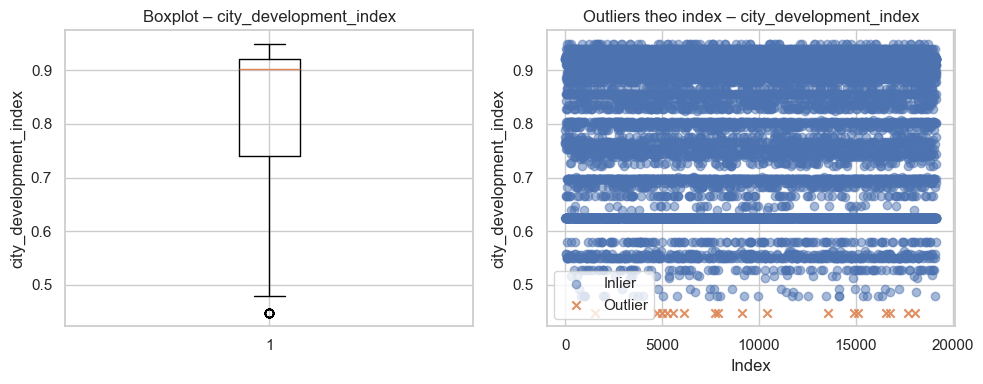

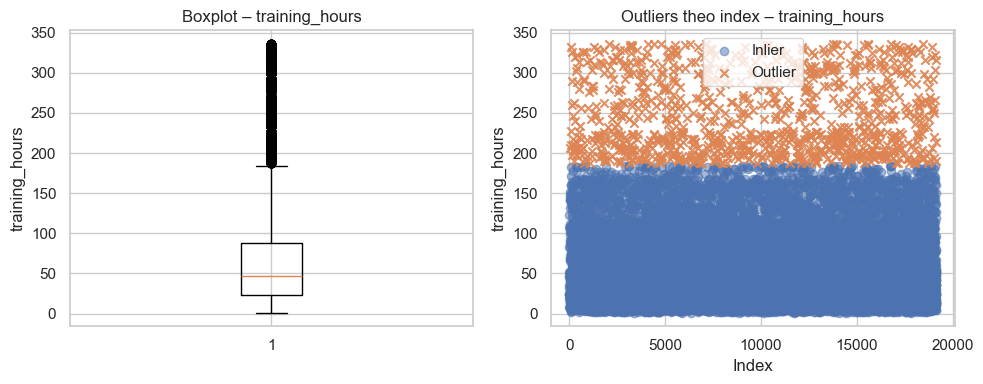

In [16]:
for name, arr in numeric_arrays.items():
    mask_out = detect_outliers_iqr(arr)
    plot_outliers(arr, mask_out, name)

#### **Nhận xét**

Biểu đồ cho thấy sự đối lập hoàn toàn về cách phân bố ngoại lai giữa hai biến định lượng này:

**1. `city_development_index` (Chỉ số phát triển thành phố):**
* **Số lượng Outliers:** Rất ít, chỉ có **17** mẫu (chiếm tỷ lệ không đáng kể).
* **Vị trí:** Nằm ở phía **dưới** (Low extreme values).
* **Ý nghĩa:** Đây là phân phối lệch trái (Left-skewed). Các điểm ngoại lai đại diện cho một nhóm rất nhỏ ứng viên đến từ các thành phố kém phát triển (Index < 0.5), trong khi đại đa số nằm ở vùng phát triển cao.
* **Hướng xử lí cho phần preprocessing:** Do số lượng quá ít và không phải lỗi dữ liệu, có thể **giữ nguyên**.

**2. `training_hours` (Số giờ đào tạo):**
* **Số lượng Outliers:** Rất lớn, lên tới **984** mẫu (chiếm khoảng ~5% dữ liệu).
* **Vị trí:** Nằm tập trung dày đặc ở phía **trên** (High extreme values).
* **Ý nghĩa:** Phân phối lệch phải (Right-skewed). Các outlier này không phải nhiễu (noise) mà là **tín hiệu thật** (valid data points), đại diện cho nhóm ứng viên cực kỳ chăm chỉ (học > 180 giờ), khác biệt hẳn so với mặt bằng chung (học ~50 giờ).
* **Hướng xử lí cho phần preprocessing:**
   - **Không nên xóa:** Vì đây là thông tin quan trọng (chẳng hạn như: có thể nhóm học nhiều sẽ ít nhảy việc hơn).
   - **Cần Transformation:** Nên dùng **Log Transformation** hoặc **Robust Scaler** để giảm bớt ảnh hưởng của các giá trị cực đại này khi đưa vào mô hình.

## III. Phân phối của các feature
### **Phân phối của Target**

Phân phối target:
target=0 : 14381 mẫu (75.07%)
target=1 : 4777 mẫu (24.93%)



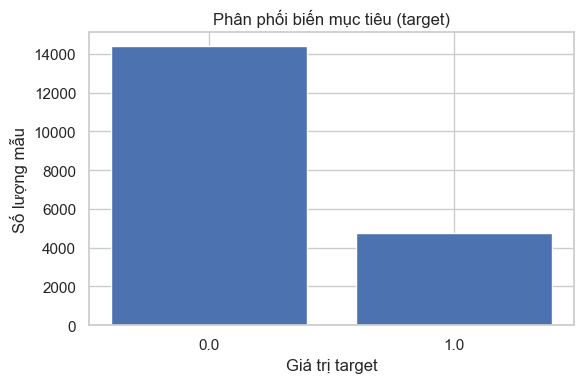

In [17]:
target = get_numeric_array("target")

plot_target_distribution(target)

#### **Nhận xét**
Phân phối của biến `target` cho thấy hiện tượng **mất cân bằng dữ liệu mức độ trung bình (Moderate Imbalance)**:

* **Nhóm ở lại (`target=0`):** Chiếm đa số với **75.07%**.
* **Nhóm muốn chuyển việc (`target=1`):** Chiếm **24.93%** (Tỷ lệ khoảng 1:3).

**Ảnh hưởng:**
1. **Rủi ro:** Mô hình có xu hướng thiên vị nhóm đa số (`0`). Nếu dự đoán "toàn bộ là 0", độ chính xác mặc nhiên đạt ~75% (Null Accuracy), nhưng mô hình vô dụng.
2. **Đánh giá:** Không sử dụng *Accuracy* làm thước đo chính. Cần tối ưu hóa **F1-Score** và **ROC-AUC**.
3. **Xử lý:**
   - Cần thiết lập `stratify=y` khi chia tập Train/Test để đảm bảo tỷ lệ 25% được giữ nguyên trong cả hai tập.
   - Có thể cân nhắc kỹ thuật *Class Weighting* hoặc *Resampling (SMOTE)* nếu mô hình dự đoán kém trên nhóm 1.
---

### **Phân phối cho numeric**

Ở phần này, ta quan sát phân phối của các feature dạng numeric bằng **Histogram**, **KDE** và **ECDF**.

- **Histogram**: cho thấy tần suất xuất hiện của giá trị trong từng khoảng → nhìn được độ lệch và dạng phân phối.  
- **KDE**: đường mật độ mượt giúp nhận biết xu hướng tổng thể và số lượng mode.  
- **ECDF**: biểu diễn tỷ lệ dữ liệu ≤ một giá trị để dễ thấy median, các bước nhảy và mức độ tích lũy.

Feature city_development_index:


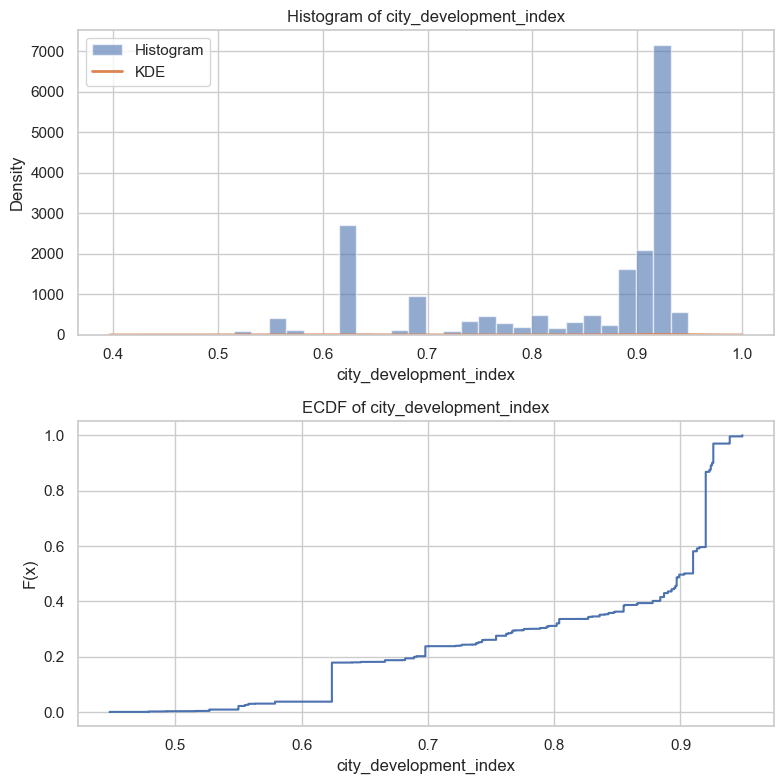

Feature training_hours:


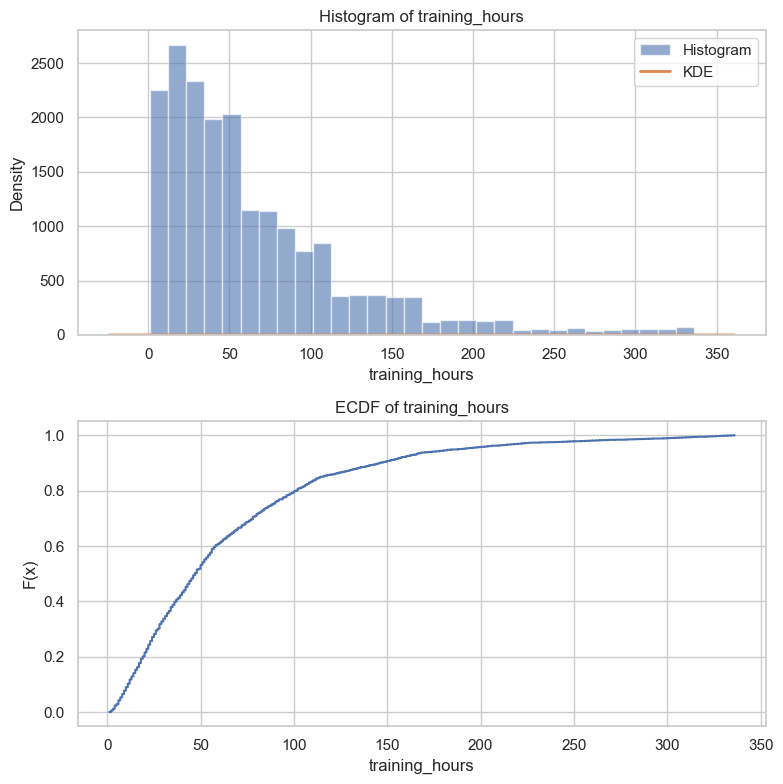

In [18]:
for name, arr in numeric_arrays.items():
    print(f"Feature {name}:")
    fig, axes = plt.subplots(2, 1, figsize=(8, 8))
    plot_numeric_distribution(arr, name, bins=30, show_kde=True, log_scale=False, ax=axes[0])
    plot_ecdf(arr, name, ax=axes[1])
    plt.tight_layout()
    plt.show()

#### **Nhận xét**

Giống với phân tích ở phần thống kê mô tả, hai feature numeric này có hình dáng phân phối trái ngược nhau hoàn toàn, đòi hỏi các kỹ thuật xử lý khác nhau:

1. `training_hours` (Số giờ đào tạo) - Phân phối lệch phải (Right-Skewed)
  * **Hình dáng (Histogram):** Dữ liệu có dạng giống phân phối **Log-normal** hoặc **Exponential**. Đỉnh (Peak) tập trung ở vùng giá trị thấp (khoảng 20-50 giờ). Đuôi bên phải kéo rất dài.
  * **Tích lũy (ECDF):**
      * Đường cong tăng rất dốc ở đoạn đầu: Khoảng **80% ứng viên** có số giờ training dưới **100 giờ**.
      * Đoạn sau phẳng lì: Chỉ có một nhóm rất nhỏ (top 5%) có số giờ training > 200.
  * **Kết luận:** Đa số mọi người chỉ học các khóa ngắn hạn.
  * **Hướng xử lý cho phần preprecessing:** Có thể sẽ áp dụng **Log Transformation** (lấy logarit) hoặc **Box-Cox Transformation** để đưa phân phối về dạng gần chuẩn (Normal) hơn, giúp mô hình học tốt hơn.

2. `city_development_index` (Chỉ số phát triển) - Phân phối đa đỉnh & Lệch trái
  * **Hình dáng (Histogram):** Không tuân theo phân phối chuẩn. Nó là phân phối **Đa đỉnh (Multimodal)**:
      * Đỉnh chính (Major Peak): Rất cao ở vùng **> 0.9** (các thành phố rất phát triển).
      * Đỉnh phụ (Minor Peak): Một nhóm nhỏ tập trung quanh mức **0.62**.
  * **Tích lũy (ECDF):**
      * Đường ECDF có dạng **bậc thang (Step function)** thay vì đường cong mượt.
      * **Ý nghĩa:** Điều này chứng tỏ giá trị `city_development_index` không liên tục ngẫu nhiên mà bị ngắt quãng theo từng nhóm thành phố cụ thể.
  * **Kết luận:** Dữ liệu bị phân cực. Ứng viên chủ yếu đến từ các "siêu đô thị" (Index > 0.9).
  * **Hướng xử lý cho phần preprecessing:** Có thể cân nhắc **Binning** (chia nhóm) biến này thành các khoảng (ví dụ: High, Medium, Low) thay vì để nguyên giá trị số thực, để mô hình dễ bắt được các cụm (cluster) này. Hoặc nếu có nhiều thời gian hơn, ta vẫn giữ biến này ở dạng numeric liên tục (clip + z-score), và vừa mở rộng thêm một phiên bản binned (Low/Medium/High) để thử trong modeling.

---
### **Phân phối các biến categorical**

Ở phần này, ta trực quan hóa các feature dạng *categorical* bằng **biểu đồ bar** và **biểu đồ tròn (pie chart)**.

- **Bar chart**: cho thấy số lượng/tần suất từng category, dễ so sánh giữa các nhóm.  
- **Pie chart**: giúp quan sát tỷ lệ phần trăm của các nhóm chính, phù hợp khi chỉ xem top-k category.  
- Với các feature có quá nhiều giá trị (như `city`), ta chỉ xem **top 10** để biểu đồ rõ ràng hơn.

Từ đó ta có thể đánh giá được bộ dữ liệu này sẽ chủ yếu là 'nhóm người' như thế nào.

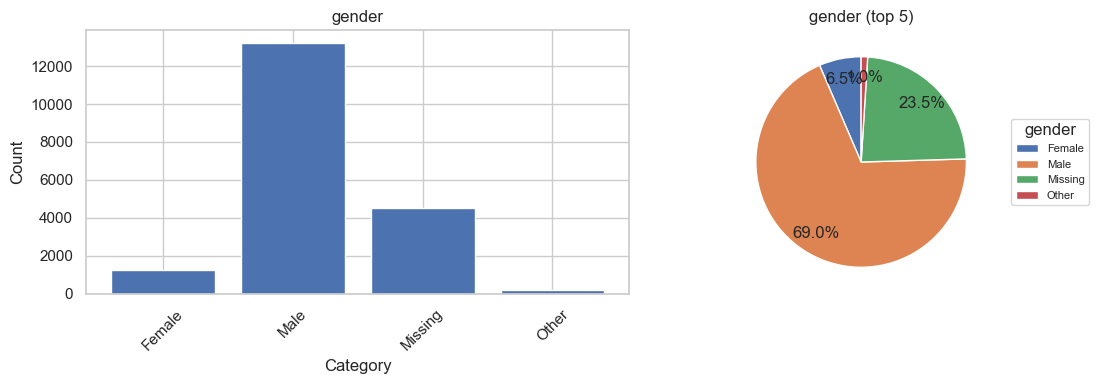

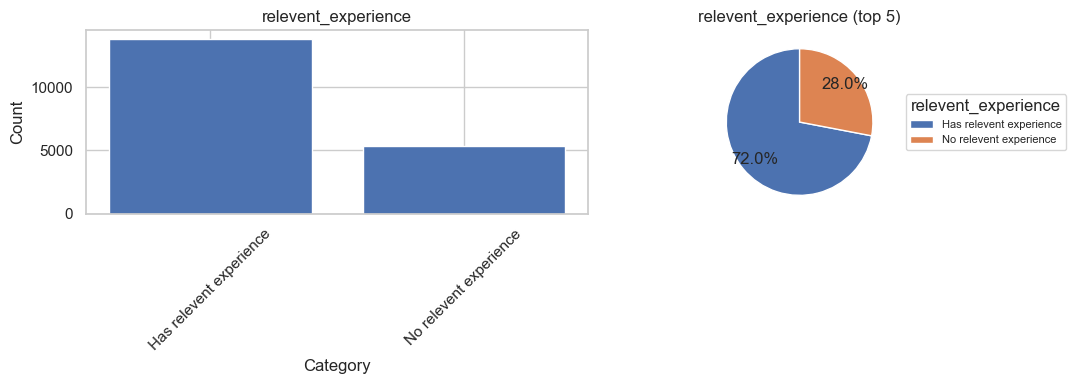

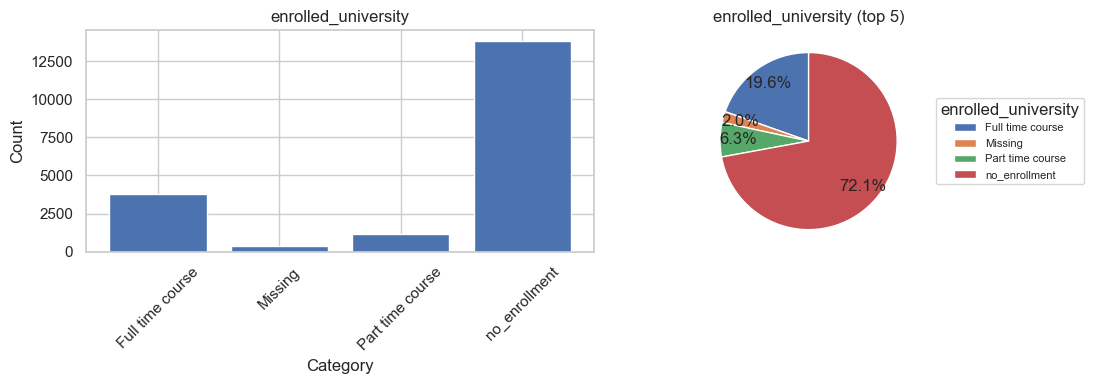

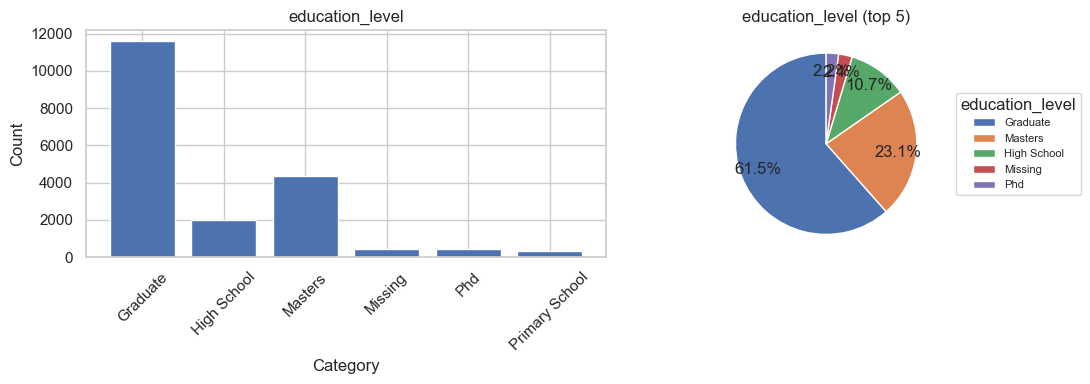

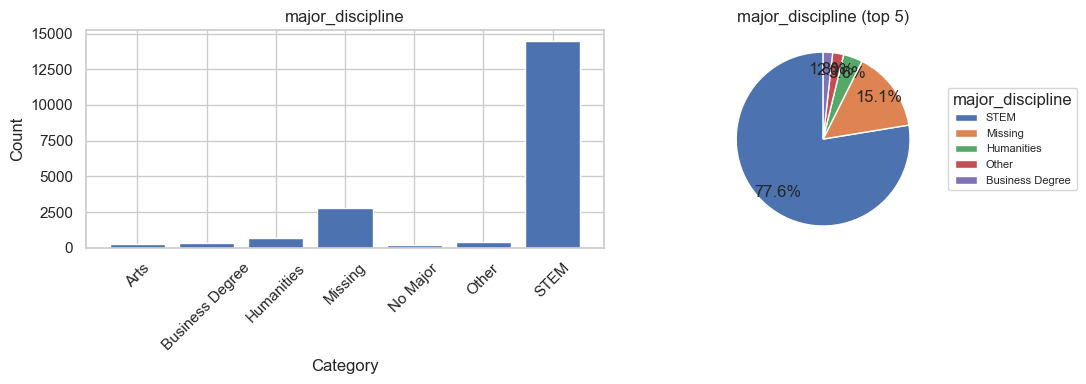

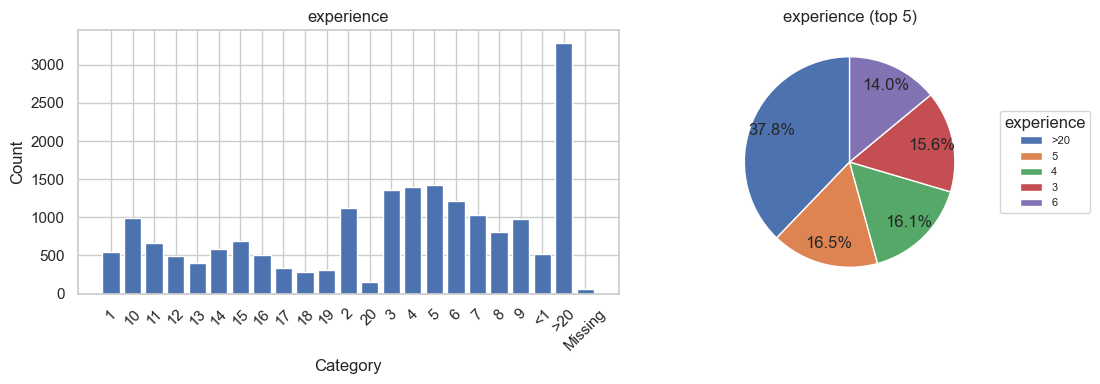

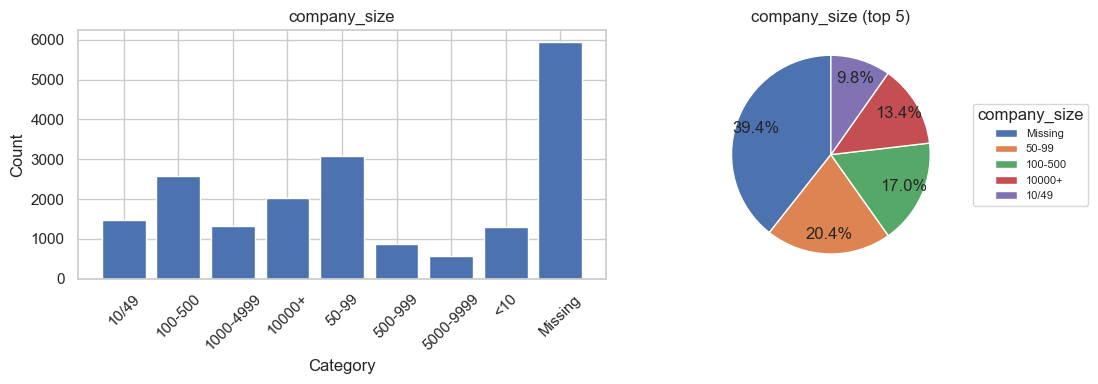

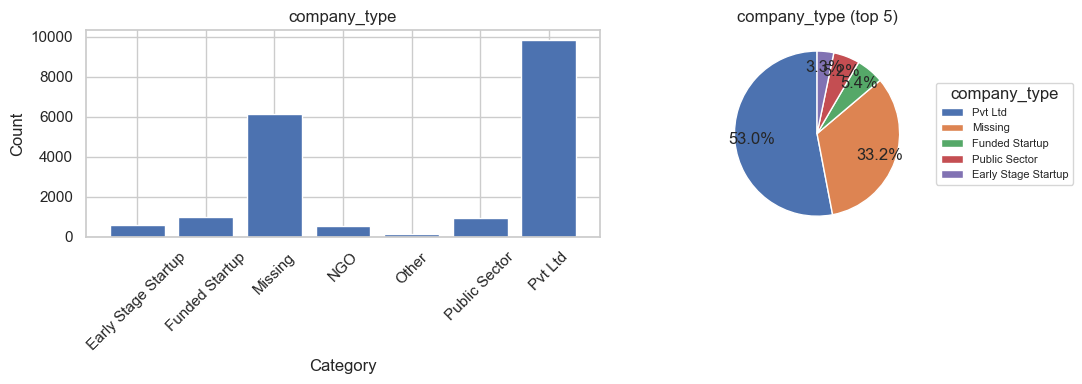

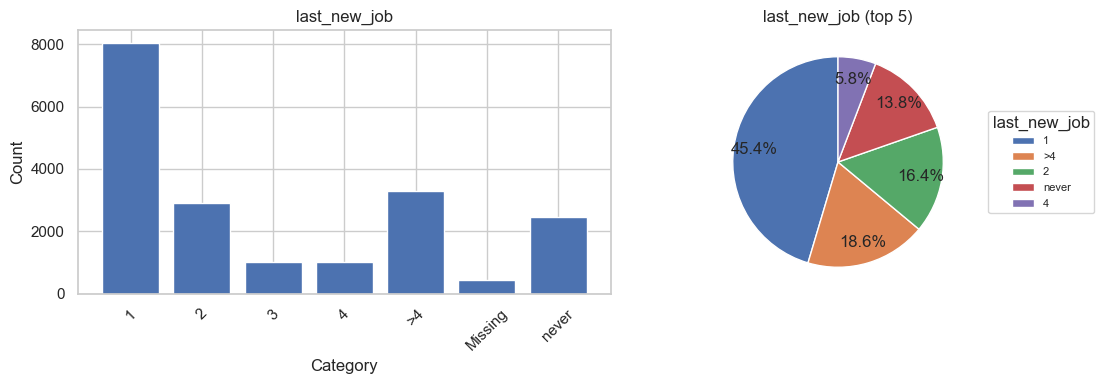

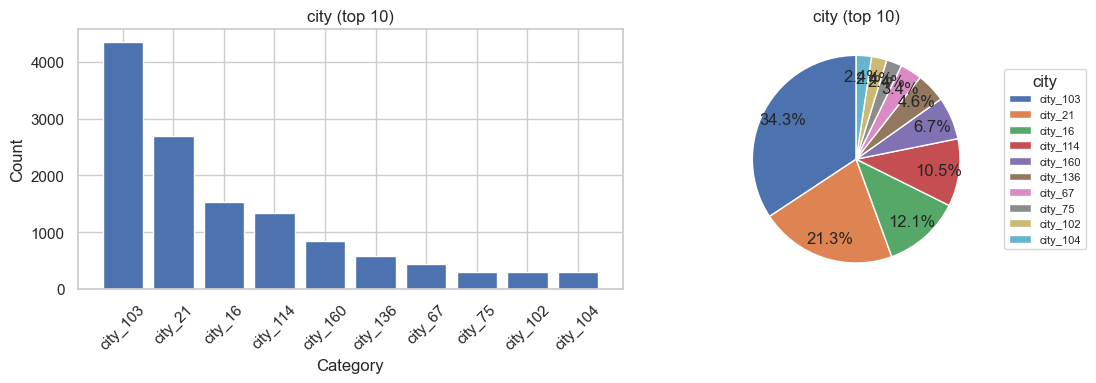

In [19]:
for col_name in categorical_cols_raw:
    if col_name == "city":
        continue
    col_data = get_col(col_name)

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    plot_categorical_distribution(col_data, col_name, ax=axes[0])
    plot_pie(col_data, col_name, top_k=5, ax=axes[1])
    plt.tight_layout()
    plt.show()

city_col = get_col("city")
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_categorical_distribution(city_col, "city (top 10)", top_k=10, ax=axes[0])
plot_pie(city_col, "city", top_k=10, ax=axes[1])
plt.tight_layout()
plt.show()
# Note: title 'Missing' nghĩa là Missing value trong feauture

#### **Nhận xét**

Ta sẽ bỏ qua về phần phân tích từng feature vì điều đó đã được nói rõ ở phần "Thống kê mô tả" vì vậy ở đây ta sẽ tập trung vào phần phân tích dựa trên sự kết hợp các feature cũng như liên hệ với thực tế hơn. Dựa trên trực quan hóa dữ liệu, ta có thể phác họa rõ nét **"Đặc điểm ứng viên" (Candidate Persona)** và các đặc điểm nổi bật của tập dữ liệu:

1. Đặc điểm của ứng viên kiểu "Dân Tech chuyên môn cao & Dày dạn kinh nghiệm"
   * **Trình độ học vấn (`education_level` & `major_discipline`):**
       * Nhóm ngành **STEM** chiếm vị thế độc tôn (**77.6%**).
       * Đa số ứng viên có bằng Đại học (**Graduate - 61.5%**) hoặc Thạc sĩ (**Masters - 23.1%**).
       * $\to$ Đây là tập dữ liệu của giới trí thức kỹ thuật, nhân sự chất lượng cao.
   * **Kinh nghiệm làm việc (`relevent_experience` & `experience`):**
       * **72%** ứng viên đã có kinh nghiệm làm việc liên quan đến lĩnh vực này.
       * Nhóm nhân sự cấp cao (**>20 năm kinh nghiệm**) chiếm tỷ trọng lớn nhất trong phân phối kinh nghiệm.
   * **Tình trạng hiện tại (`enrolled_university`):**
       * **72.1%** không còn đi học (`no_enrollment`), khẳng định đây là nhóm nhân sự đang đi làm toàn thời gian.

2. Hành vi nghề nghiệp & Môi trường làm việc
   * **Loại hình công ty (`company_type`):**
       * Phần lớn làm việc tại các công ty Tư nhân (**Pvt Ltd**), chiếm **53%**. Các mô hình Startup hay NGO chiếm tỷ lệ rất nhỏ.
   * **Quy mô công ty (`company_size`):**
       * Dữ liệu tại cột này bị khuyết rất nhiều (**~40% là Missing**). Trong số những người khai báo, nhóm công ty quy mô nhỏ (50-99 nhân viên) chiếm đa số.
   * **Tần suất nhảy việc (`last_new_job`):**
       * Nhóm phổ biến nhất là **1 năm** (**45.4%**). Điều này cho thấy sự biến động nhân sự trong ngành Tech khá cao, ứng viên có xu hướng thay đổi môi trường hoặc mới bắt đầu công việc mới gần đây.

3. Các yếu tố về Nhân khẩu học & Địa lý
   * **Giới tính (`gender`):**
       * Mất cân bằng nghiêm trọng với **Nam giới** chiếm đa số. Tuy nhiên, lượng dữ liệu bị thiếu (`Missing`) ở cột này cũng rất cao (**23.5%**).
   * **Địa lý (`city`):**
       * Có sự tập trung cục bộ mạnh mẽ. Chỉ riêng **`city_103`** đã chiếm tới **34.3%** tổng dữ liệu, cho thấy đây có thể là một "Tech Hub" lớn.

**Tóm lại:**
Bộ dữ liệu phản ánh một thị trường nhân lực trong ngành Khoa học dữ liệu chủ yếu sẽ có đặc điểm là **Nam giới**, thuộc khối **STEM**, trình độ **Đại học trở lên**, làm việc chủ yếu ở khối **Tư nhân**.

---

## IV. Mối quan hệ giữa các feature với `target`

Trong phần này, ta phân tích xem các đặc trưng (feature) liên quan thế nào đến
khả năng ứng viên muốn thay đổi công việc (`target = 1`).

Ta chia làm 2 nhóm:

### **Nhóm 1: Categorical vs `target`**

Với mỗi biến categorical quan trọng, ta sẽ:

- Nhóm dữ liệu theo từng category.
- Tính **tỷ lệ `target = 1`** trong mỗi nhóm.
- Vẽ bar chart (`plot_target_rate_by_category`) để trực quan hóa.

Phần này giúp ta hiểu thêm về:

- Ứng viên có **kinh nghiệm liên quan** (`relevent_experience`) có xu hướng đổi job
  nhiều hơn người **chưa có kinh nghiệm** không?
- **Trình độ học vấn** (`education_level`) ảnh hưởng thế nào đến khả năng đổi job?
- **Ngành học / chuyên ngành** (`major_discipline`) có tạo ra sự khác biệt đáng kể
  về tỷ lệ đổi việc không?
- Một số đặc trưng khác như `gender`, `company_size`, `company_type` có tác động gì
  đến xu hướng đổi job?
- `experience` (số năm kinh nghiệm) ảnh hưởng thế nào đến khả năng đổi việc?

### **Nhóm 2: Numeric vs `target`**

Với các biến numeric, ta sẽ:

- Dùng `boxplot_numeric_by_target`:
  - So sánh **phân phối**, **median** và **độ phân tán** giữa hai nhóm
    `target = 0` (không đổi job) và `target = 1` (muốn đổi job).
- Dùng `plot_hist_overlay_by_target`:
  - Vẽ **histogram overlay** của hai nhóm trên cùng một trục để so sánh trực quan.

Phần này giúp ta hiểu thêm về:

- `city_development_index` (chỉ số phát triển của thành phố) có mối liên hệ gì
  với xu hướng đổi job (người ở thành phố phát triển cao có dễ đổi việc hơn không)?
- `training_hours` (số giờ training) có khác biệt rõ rệt giữa người đổi job
  và không đổi job hay không?

Kết quả phân tích ở phần này sẽ là cơ sở quan trọng cho việc:
- Chọn feature quan trọng,
- Thiết kế đặc trưng (feature engineering),
- Và giải thích mô hình Logistic Regression ở các bước sau.

---

### **Nhóm 1: Categorical vs `target`**


	    Tỷ lệ target = 1 theo 'city':
--------------------------------------------------------------------------------
Category                     |      n |   rate |  % target=1
--------------------------------------------------------------------------------
city_171                     |      1 |  1.000 |     100.00%
city_139                     |      5 |  0.800 |      80.00%
city_155                     |     14 |  0.786 |      78.57%
city_42                      |     13 |  0.692 |      69.23%
city_107                     |      6 |  0.667 |      66.67%
city_33                      |     17 |  0.647 |      64.71%
city_179                     |      5 |  0.600 |      60.00%
city_11                      |    247 |  0.595 |      59.51%
city_21                      |   2702 |  0.591 |      59.10%
city_145                     |     63 |  0.587 |      58.73%
city_43                      |     12 |  0.583 |      58.33%
city_101                     |     75 |  0.573 |      57.33%
city_128 

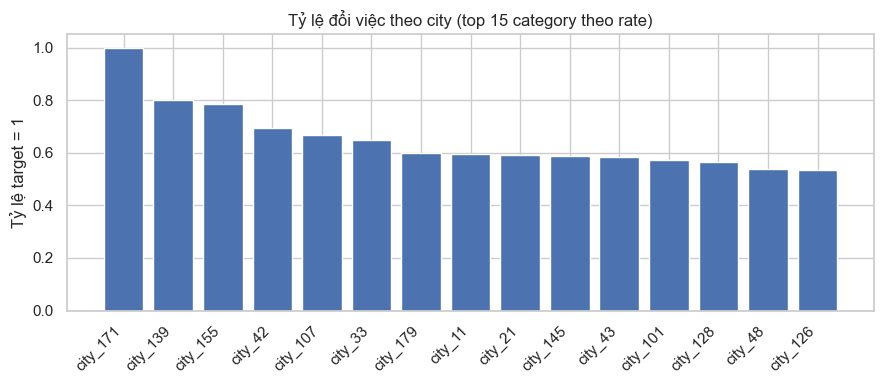


	    Tỷ lệ target = 1 theo 'gender':
--------------------------------------------------------------------------------
Category                     |      n |   rate |  % target=1
--------------------------------------------------------------------------------
MISSING                      |   4508 |  0.308 |      30.81%
Female                       |   1238 |  0.263 |      26.33%
Other                        |    191 |  0.262 |      26.18%
Male                         |  13221 |  0.228 |      22.78%


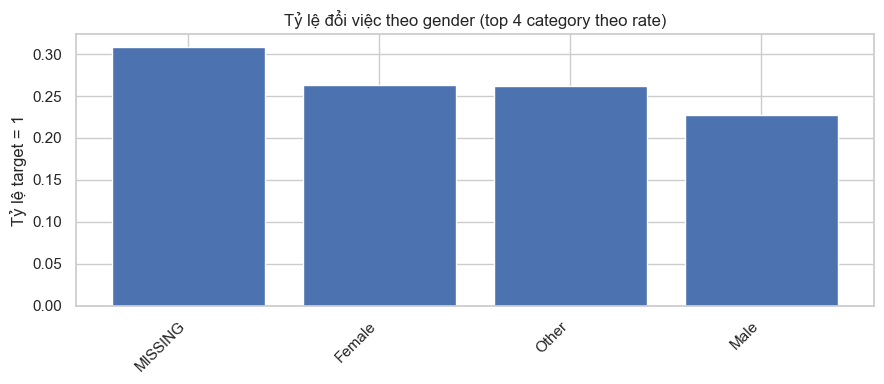


	    Tỷ lệ target = 1 theo 'relevent_experience':
--------------------------------------------------------------------------------
Category                     |      n |   rate |  % target=1
--------------------------------------------------------------------------------
No relevent experience       |   5366 |  0.338 |      33.84%
Has relevent experience      |  13792 |  0.215 |      21.47%


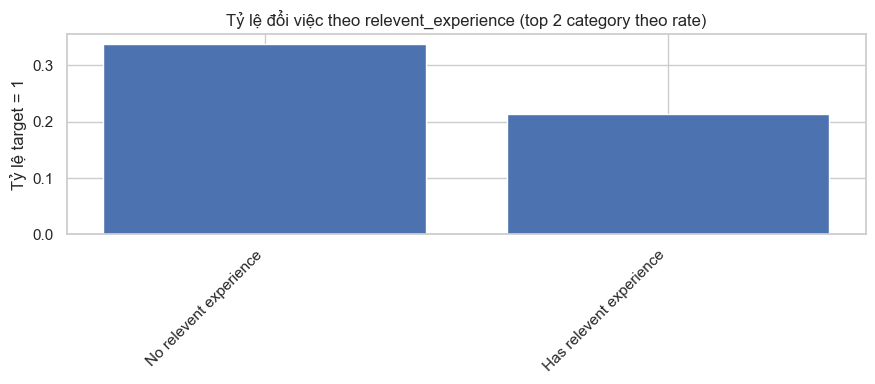


	    Tỷ lệ target = 1 theo 'enrolled_university':
--------------------------------------------------------------------------------
Category                     |      n |   rate |  % target=1
--------------------------------------------------------------------------------
Full time course             |   3757 |  0.381 |      38.09%
MISSING                      |    386 |  0.319 |      31.87%
Part time course             |   1198 |  0.252 |      25.21%
no_enrollment                |  13817 |  0.211 |      21.14%


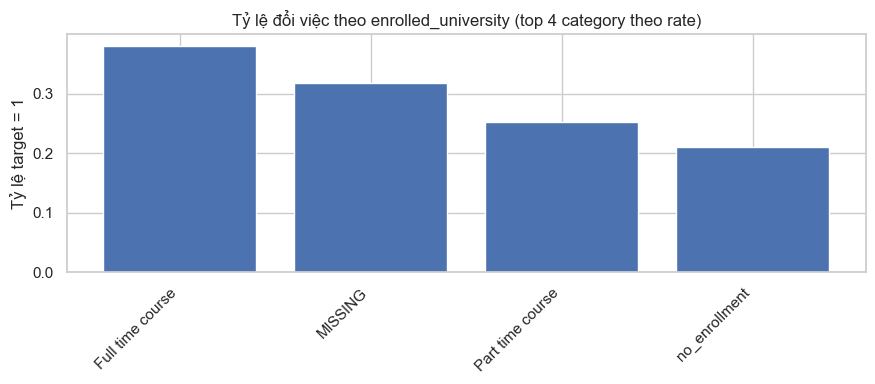


	    Tỷ lệ target = 1 theo 'education_level':
--------------------------------------------------------------------------------
Category                     |      n |   rate |  % target=1
--------------------------------------------------------------------------------
Graduate                     |  11598 |  0.280 |      27.98%
MISSING                      |    460 |  0.226 |      22.61%
Masters                      |   4361 |  0.214 |      21.44%
High School                  |   2017 |  0.195 |      19.53%
Phd                          |    414 |  0.140 |      14.01%
Primary School               |    308 |  0.133 |      13.31%


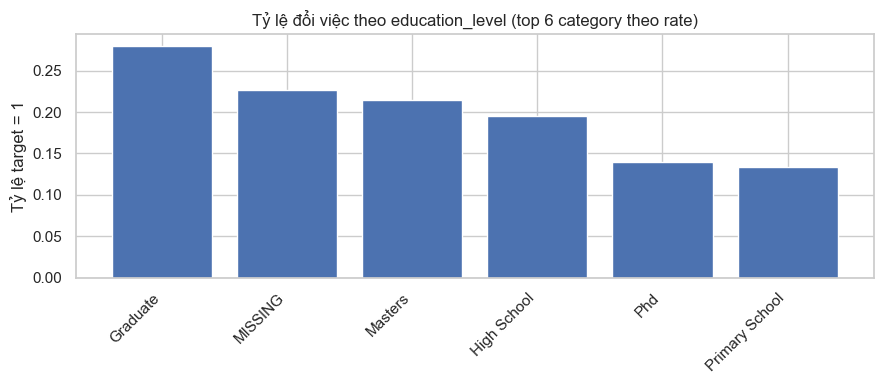


	    Tỷ lệ target = 1 theo 'major_discipline':
--------------------------------------------------------------------------------
Category                     |      n |   rate |  % target=1
--------------------------------------------------------------------------------
Other                        |    381 |  0.268 |      26.77%
Business Degree              |    327 |  0.263 |      26.30%
STEM                         |  14492 |  0.262 |      26.16%
No Major                     |    223 |  0.247 |      24.66%
Humanities                   |    669 |  0.211 |      21.08%
Arts                         |    253 |  0.209 |      20.95%
MISSING                      |   2813 |  0.195 |      19.52%


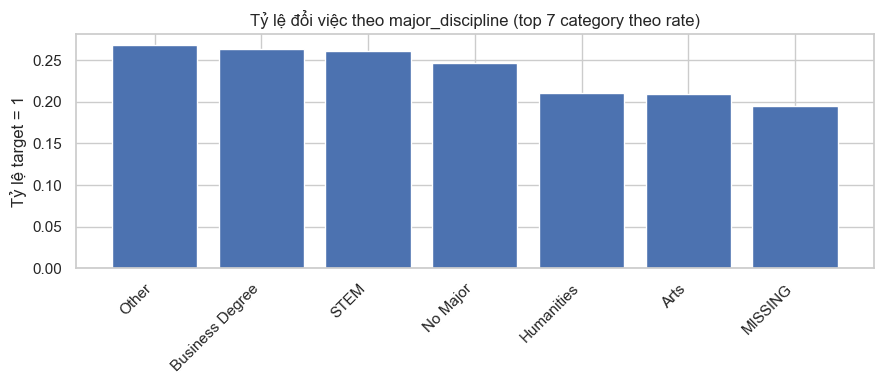


	    Tỷ lệ target = 1 theo 'experience':
--------------------------------------------------------------------------------
Category                     |      n |   rate |  % target=1
--------------------------------------------------------------------------------
<1                           |    522 |  0.454 |      45.40%
1                            |    549 |  0.424 |      42.44%
MISSING                      |     65 |  0.354 |      35.38%
3                            |   1354 |  0.353 |      35.30%
2                            |   1127 |  0.332 |      33.19%
4                            |   1403 |  0.326 |      32.57%
7                            |   1028 |  0.295 |      29.47%
5                            |   1430 |  0.288 |      28.81%
6                            |   1216 |  0.282 |      28.21%
8                            |    802 |  0.243 |      24.31%
11                           |    664 |  0.227 |      22.74%
20                           |    148 |  0.223 |      22.30%
9  

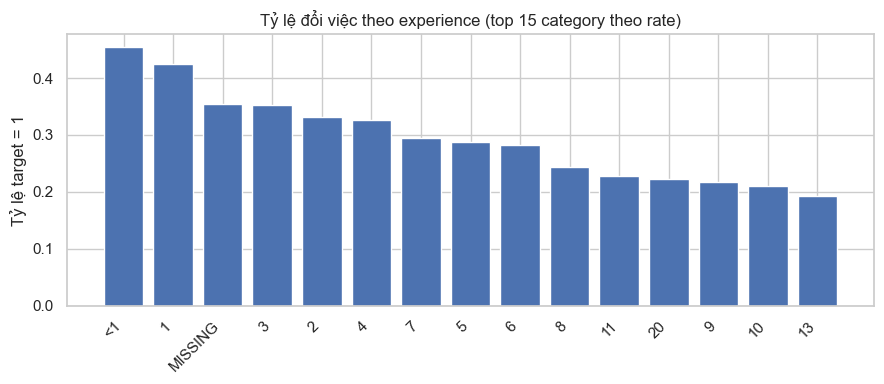


	    Tỷ lệ target = 1 theo 'company_size':
--------------------------------------------------------------------------------
Category                     |      n |   rate |  % target=1
--------------------------------------------------------------------------------
MISSING                      |   5938 |  0.406 |      40.59%
10/49                        |   1471 |  0.234 |      23.39%
10000+                       |   2019 |  0.191 |      19.07%
5000-9999                    |    563 |  0.181 |      18.12%
50-99                        |   3083 |  0.177 |      17.68%
500-999                      |    877 |  0.173 |      17.33%
<10                          |   1308 |  0.171 |      17.13%
100-500                      |   2571 |  0.161 |      16.14%
1000-4999                    |   1328 |  0.151 |      15.06%


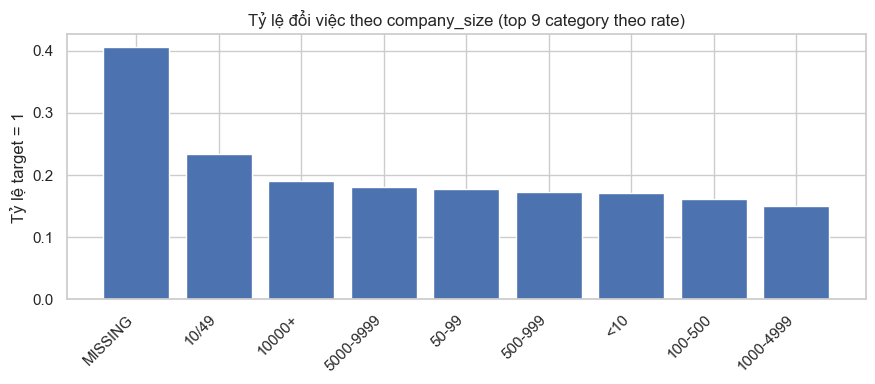


	    Tỷ lệ target = 1 theo 'company_type':
--------------------------------------------------------------------------------
Category                     |      n |   rate |  % target=1
--------------------------------------------------------------------------------
MISSING                      |   6140 |  0.388 |      38.83%
Other                        |    121 |  0.240 |      23.97%
Early Stage Startup          |    603 |  0.235 |      23.55%
Public Sector                |    955 |  0.220 |      21.99%
NGO                          |    521 |  0.186 |      18.62%
Pvt Ltd                      |   9817 |  0.181 |      18.08%
Funded Startup               |   1001 |  0.140 |      13.99%


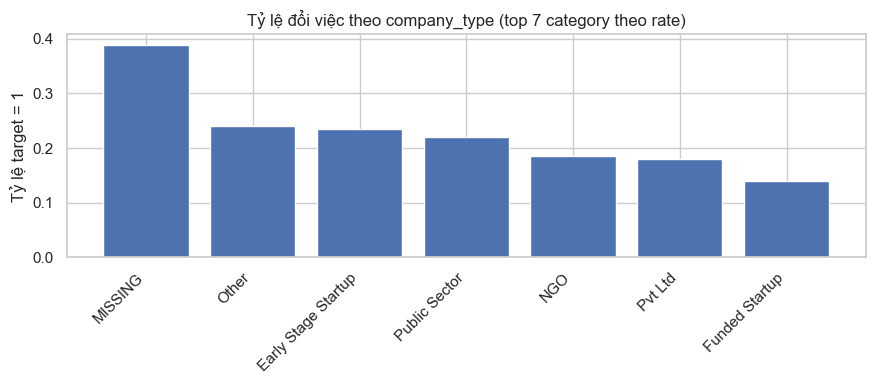


	    Tỷ lệ target = 1 theo 'last_new_job':
--------------------------------------------------------------------------------
Category                     |      n |   rate |  % target=1
--------------------------------------------------------------------------------
MISSING                      |    423 |  0.364 |      36.41%
never                        |   2452 |  0.301 |      30.14%
1                            |   8040 |  0.264 |      26.43%
2                            |   2900 |  0.241 |      24.14%
3                            |   1024 |  0.226 |      22.56%
4                            |   1029 |  0.222 |      22.16%
>4                           |   3290 |  0.182 |      18.24%


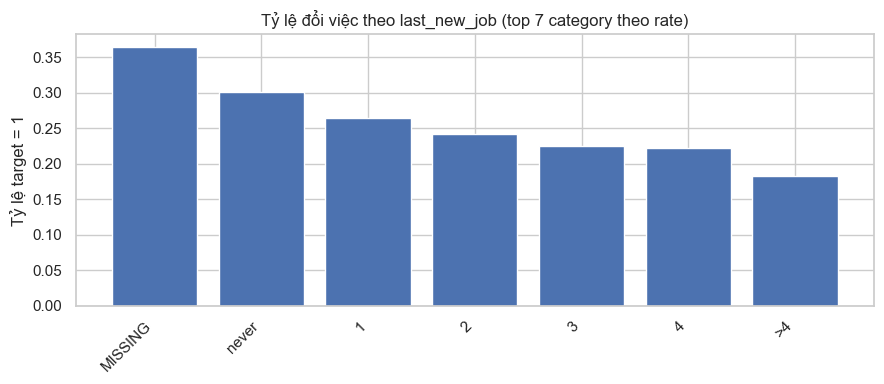

In [20]:
for col_name in categorical_cols_raw:
    col_data = get_col(col_name)
    plot_target_rate_by_category(col_data, target, col_name)

#### **Phân tích và nhận xét:**

Dựa trên biểu đồ tỷ lệ `target=1` (người muốn đổi việc) theo từng nhóm, ta rút ra các insight quan trọng sau:

1. Nhóm Kinh nghiệm & Thâm niên (`experience`, `last_new_job`, `relevent_experience`)
Đây là nhóm yếu tố có tác động mạnh mẽ nhất đến quyết định rời đi của ứng viên:
   * **Người mới (Junior/Fresher) khao khát nhảy việc nhất:**
     * Nhóm có kinh nghiệm **< 1 năm** và **1 năm** có tỷ lệ muốn đổi việc cao kỷ lục, lần lượt là **45.4%** và **42.4%**.
     * Tương tự, những người **chưa từng nhảy việc** (`last_new_job` = `never`) có tỷ lệ churn cao (**30.1%**). Đây là dấu hiệu của nhóm bắt đầu tìm kiếm cơ hội thứ hai trong sự nghiệp.
   * **Sự ổn định của nhóm Senior:**
     * Tỷ lệ muốn đổi việc giảm dần theo số năm kinh nghiệm. Nhóm thâm niên cao (**>20 năm**) hoặc đã làm ổn định ở công ty cũ (**>4 năm**) có tỷ lệ thấp nhất (chỉ khoảng **18-22%**).
   * **Nghịch lý về Kinh nghiệm liên quan:**
     * Nhóm **không có kinh nghiệm liên quan** (`No relevent experience`) lại có tỷ lệ muốn đổi việc cao hơn (**33.8%**) so với nhóm có kinh nghiệm (**21.5%**).
     * *Insight:* Khả năng cao đây là nhóm **Career Switchers** (chuyển ngành) đang tích cực tìm kiếm cơ hội để gia nhập ngành Data Science.

2. Nhóm Học vấn & Chuyên ngành (`education_level`, `major_discipline`, `enrolled_university`)
   * **Trình độ và Trạng thái học tập:**
     * Những người đang đi học toàn thời gian (`Full time course`) có tỷ lệ đổi việc cao nhất bảng (**38.1%**).
     * Nhóm trình độ **Graduate** (Đại học) có tỷ lệ churn cao nhất (**28.0%**), cao hơn hẳn Thạc sĩ (**21.4%**) và thấp nhất là Tiến sĩ (**Phd - 14.0%**).
   * **Thị trường STEM sôi động:**
     * Nhóm ngành Kỹ thuật (`STEM`) và Kinh doanh (`Business Degree`) có tỷ lệ nhảy việc cao (**~26.2%**). Do nhu cầu thị trường lớn, họ dễ dàng tìm được bến đỗ mới.
     * Ngược lại, nhóm Xã hội (`Arts`, `Humanities`) có xu hướng ổn định hơn (~21%).
   * **Nghịch lý Missing Data ở Ngành học:**
     * Trái ngược với các biến khác, nhóm không điền chuyên ngành (`MISSING`) lại có tỷ lệ đổi việc **thấp nhất** (**19.5%**). Có thể do những người không có chuyên môn cụ thể cảm thấy khó cạnh tranh nên có xu hướng bám trụ lại công việc hiện tại. Vì do ngành học cần phải học đại học vì thế những người chỉ có bằng thấp hơn đại học ít có sự lựa chọn hơn nên họ sẽ không muốn rời đi sau khóa học.

3. Nhóm Công ty & Dữ liệu ẩn (`company_size`, `company_type`)
   * **"Missing Value" là tín hiệu dự báo mạnh (Strong Signal):**
     * Ở cả hai biến về công ty, nhóm **không điền thông tin (MISSING)** luôn có tỷ lệ `target=1` cao đột biến (**~38-40%**).
     * *Insight:* Việc ứng viên cố tình ẩn thông tin công ty hiện tại là chỉ báo rõ ràng cho thấy họ đang thất nghiệp hoặc che giấu thông tin công ti hiện tại.
   * **Môi trường Startup:**
     * **Funded Startup** (Startup đã gọi vốn) là nơi giữ chân nhân tài tốt nhất với tỷ lệ churn chỉ **14.0%**, thấp hơn cả công ty tư nhân truyền thống (`Pvt Ltd` - 18.1%).

4. Nhóm Giới tính (`gender`)
   * **Người "ẩn danh" muốn ra đi:** Nhóm không khai báo giới tính (`MISSING`) tiếp tục dẫn đầu về tỷ lệ muốn đổi việc (**30.8%**). Điều này nhất quán với quy luật ở biến Company: Ứng viên càng giấu thông tin cá nhân, xác suất họ đang tìm việc càng cao.
   * **Nữ giới có xu hướng đổi việc cao hơn:** Tỷ lệ ở nhóm Nữ (`Female`) là **26.3%**, cao hơn đáng kể so với Nam (`Male`) là **22.8%**. Điều này có thể phản ánh nhu cầu tuyển dụng nhân sự nữ trong ngành Tech/Data đang cao (xu hướng Diversity), tạo cho họ nhiều cơ hội dịch chuyển hơn.

5. Nhóm Địa lý (`city`)
   * Có sự phân hóa cực lớn giữa các thành phố. Một số thành phố (như `city_21`) có tỷ lệ nhân sự muốn ra đi lên tới **59.1%**, gợi ý rằng vị trí địa lý là một biến số quan trọng (Predictive Feature) cần được đưa vào mô hình.

**Kết luận:**
Đặc điểm ứng viên có khả năng rời đi cao nhất là: **Kinh nghiệm ít (<1 năm), đang học Full-time, tốt nghiệp Đại học ngành STEM/Business, là Nữ giới và thường giấu thông tin bỏ trống (Công ty/Giới tính).**

---

### **Nhóm 2: Numeric vs target**

Feature city_development_index vs target:


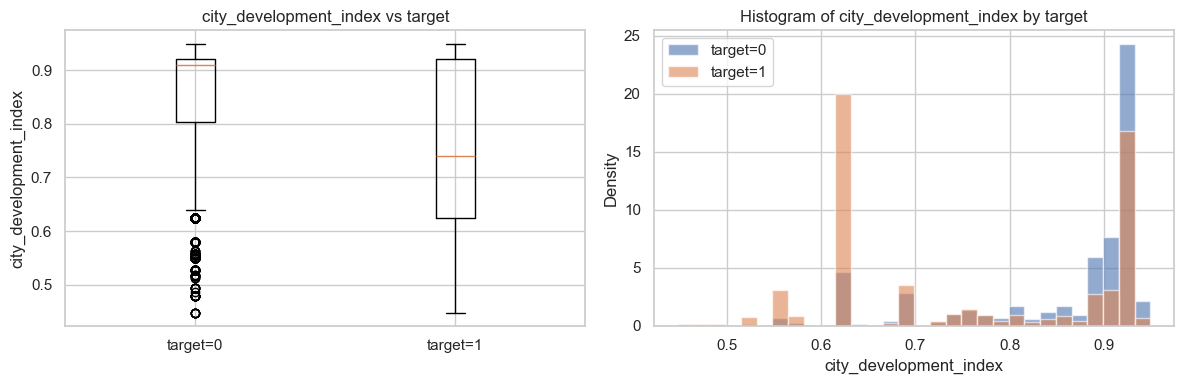

Feature training_hours vs target:


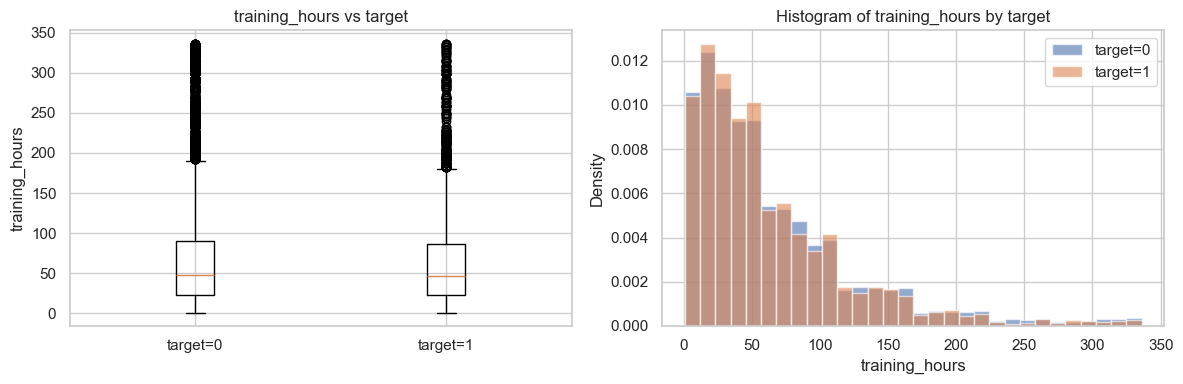

In [21]:
for name, arr in numeric_arrays.items():
    print(f"Feature {name} vs target:")
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    boxplot_numeric_by_target(arr, target, name, ax=axes[0])
    plot_hist_overlay_by_target(arr, target, name, bins=30, ax=axes[1])
    plt.tight_layout()
    plt.show()

### **Phân tích và nhận xét**

Dựa trên biểu đồ Boxplot và Histogram phân tách theo `target`, ta thấy sự tương phản rõ rệt về mức độ quan trọng giữa hai biến số này:

1. `city_development_index` (Chỉ số phát triển thành phố) - Biến dự báo MẠNH
Đây là một trong những đặc trưng quan trọng nhất để phân loại ứng viên:
   * **Sự chênh lệch về Trung vị (Median):**
     * Nhóm **ở lại (`target=0`)**: Có trung vị rất cao (tiệm cận **0.92**). Hộp dữ liệu (Box) nằm co cụm ở phía trên, cho thấy đa số người ở lại đều sống ở các thành phố rất phát triển.
     * Nhóm **muốn đi (`target=1`)**: Có trung vị thấp hơn hẳn (khoảng **0.74**) và dải phân bố trải rộng hơn nhiều (từ 0.6 đến 0.9).
   * **Phân phối Histogram:**
     * Tại ngưỡng Index thấp (**~0.62**): Tỷ lệ cột màu cam (`target=1`) rất cao, thậm chí lấn át màu xanh. Điều này ám chỉ ứng viên ở các thành phố đang phát triển có xu hướng muốn nhảy việc cực cao (có thể để tìm cơ hội ở nơi tốt hơn).
     * Tại ngưỡng Index cao (**>0.9**): Cột màu xanh (`target=0`) chiếm ưu thế tuyệt đối.
   * **Insight:** Có mối tương quan ngược chiều rõ rệt. **Thành phố càng kém phát triển, xu hướng muốn rời đi càng cao.**

2. `training_hours` (Số giờ đào tạo) - Biến dự báo YẾU
Ngược lại với biến trên, số giờ đào tạo không cho thấy sự khác biệt rõ ràng giữa hai nhóm:
   * **Phân phối trùng lắp (Overlapping):**
     * Trên biểu đồ Boxplot, hai hộp `target=0` và `target=1` gần như **giống hệt nhau** về trung vị (khoảng 47 giờ), độ trải giữa (IQR) và cả các giá trị ngoại lai (Outliers).
     * Trên biểu đồ Histogram, hai đường phân phối chồng khít lên nhau.
   * **Insight:** Thời gian học nhiều hay ít **không ảnh hưởng trực tiếp** đến quyết định nhảy việc. Dù ứng viên học 10 giờ hay 200 giờ, tỷ lệ muốn đổi việc là như nhau.
   * **Lưu ý:** Mặc dù phân phối giống nhau, nhưng biến này vẫn có thể hữu ích khi kết hợp (interaction) với các biến khác trong mô hình phi tuyến tính, nên chưa cần loại bỏ vội.

**Kết luận:**
Trong nhóm biến định lượng, **`city_development_index`** là "ngôi sao sáng" với khả năng phân tách nhóm tốt, trong khi **`training_hours`** có sức mạnh dự báo độc lập khá yếu.

---

## V. Quan hệ giữa các biến numeric & tương quan
**Phần này sẽ:**

- Vẽ scatter plot giữa các cặp biến numeric (`plot_scatter`).
- Vẽ scatter matrix (`plot_scatter_matrix`) cho nhóm numeric.
- Tính ma trận tương quan Pearson & Spearman:
  - Dùng `np.corrcoef`.
- Vẽ heatmap (`plot_correlation_heatmap`) để xem:
  - Biến nào đồng biến / nghịch biến mạnh.
  - Có multicollinearity (các biến quá giống nhau) hay không?

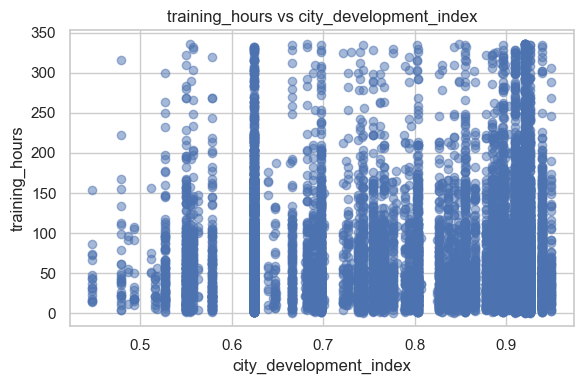

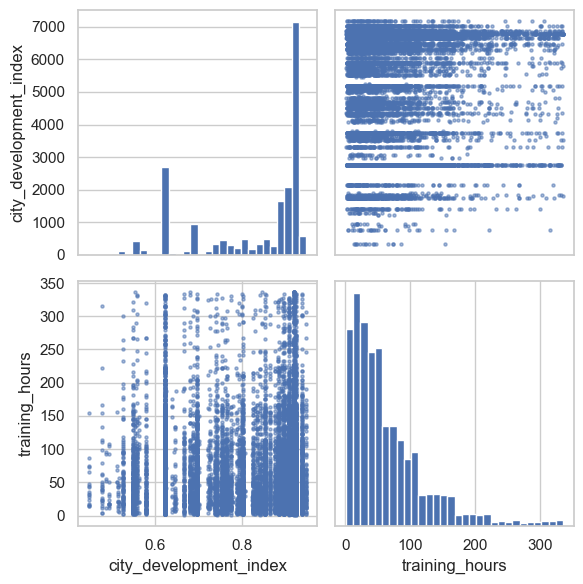

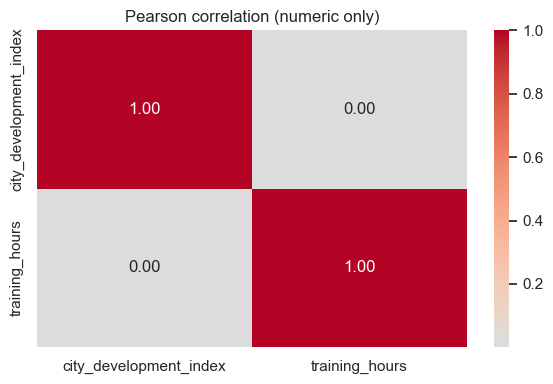

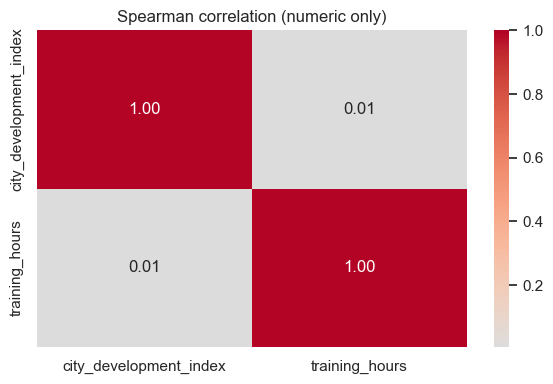

In [22]:
# Numeric thuần
cdi = get_numeric_array("city_development_index")
training_hours = get_numeric_array("training_hours")

# Matrix numeric 2 biến
num_matrix = np.vstack([cdi, training_hours]).T
mask_valid = ~np.isnan(num_matrix).any(axis=1)
num_matrix_clean = num_matrix[mask_valid]

feature_names = [
    "city_development_index",
    "training_hours",
]

# Scatter plot giữa 2 biến numeric
plot_scatter(
    num_matrix_clean[:, 0],
    num_matrix_clean[:, 1],
    "city_development_index",
    "training_hours"
)

# Scatter matrix (2 biến)
plot_scatter_matrix(num_matrix_clean, feature_names)

# Pearson correlation
corr_pearson = np.corrcoef(num_matrix_clean, rowvar=False)
plot_correlation_heatmap(corr_pearson, feature_names, title="Pearson correlation (numeric only)")

# Spearman correlation
ranked = np.apply_along_axis(lambda v: v.argsort().argsort(), 0, num_matrix_clean)
corr_spearman = np.corrcoef(ranked, rowvar=False)
plot_correlation_heatmap(corr_spearman, feature_names, title="Spearman correlation (numeric only)")

## VI. Các câu hỏi giúp hiểu sâu về bộ dữ liệu
Sau khi đã hiểu về bộ dữ liệu ta tiến hành đặt các câu hỏi nâng cao hơn để có thể hiểu sâu hơn về bộ dữ liệu này giúp cho quá trình tiền xử lí và xây dựng model đạt kết quả tốt.

### **Câu hỏi 1 – Các feature đơn lẻ ảnh hưởng đến khả năng đổi job thì các cụm feature có ảnh hưởng đến hay không?**

**Cụ thể**

Dựa trên các đặc trưng chính:
- `experience` (số năm kinh nghiệm),
- `last_new_job` (số năm từ lần đổi việc gần nhất),
- `training_hours` (số giờ training),
- `city_development_index` (mức độ phát triển của thành phố),

liệu có thể xây dựng được một số cụm feature với nguy cơ đổi job khác nhau không?  
Nói cách khác: *những kiểu ứng viên nào (tổ hợp kinh nghiệm – lịch sử đổi job – mức độ training – bối cảnh thành phố) có tỷ lệ muốn đổi job cao nhất?*

**Mục tiêu**

- Không chỉ phân tích từng biến riêng lẻ, mà **nhóm ứng viên theo nhiều yếu tố cùng lúc** để tạo thành các bộ feauture dễ hiểu.
- Với mỗi profile:
  - Mô tả rõ ràng đặc trưng (khoảng kinh nghiệm, khoảng last_new_job, mức training, mức CDI),
  - Tính **tỷ lệ `target = 1`** để xác định đâu là nhóm **“dễ nhảy việc”** nhất.
- Kết quả giúp doanh nghiệp biết **nên chú ý / ưu tiên nhóm ứng viên nào** trong chiến lược thu hút và giữ chân nhân sự.

**Cách tiếp cận**
1. Chia mỗi biến thành các nhóm (bins) có ý nghĩa:
   - `experience` → `≤1 năm`, `1–3 năm`, `3–7 năm`, `>7 năm`,
   - `last_new_job` → `≤1 năm`, `1–2 năm`, `2–4 năm`, `>4 năm`,
   - `training_hours` → chia theo các mức `Thấp`, `Trung bình`, `Cao`, `Rất cao` (dựa trên các quantile),
   - `city_development_index` → `CDI thấp`, `CDI trung bình`, `CDI cao`.
2. Định nghĩa “bộ feature” là một tổ hợp 4 chiều:
   (nhóm kinh nghiệm, nhóm last_new_job, nhóm training, nhóm CDI)
3. Với mỗi bộ feature:
   - Đếm số ứng viên thuộc bộ feauture đó,
   - Tính tỷ lệ `target=1` trong bộ feauture.


In [23]:
visualize_q1_risk_profiles(experience, last_new_job, training_hours, cdi, target)

NameError: name 'experience' is not defined

#### **Nhận xét kết quả**
- **Điểm chung lớn nhất** của tất cả các bộ feature khả năng cao là:
  - Đều có `last_new_job ≤ 1 năm` → những ứng viên **mới đổi job gần đây** lại chính là nhóm có **xác suất muốn tiếp tục đổi job** cao nhất.
  - Điều này cho thấy lịch sử “last_new_job” là một **tín hiệu khả năng mạnh**.

- Có hai nhóm nổi bật:

  1. **Mid-level, CDI thấp, mới đổi job:**
     - Các bộ feature P01, P03, P04 đều có:
       - `experience` từ **3–7 năm**,
       - `last_new_job ≤ 1 năm`,
       - `CDI thấp`.
     - Tỷ lệ `target=1` dao động khoảng **58–62%**.
     - Đây là nhóm ứng viên đã có kinh nghiệm nhưng đang ở thành phố kém phát triển, có thể **chưa hài lòng với cơ hội hiện tại** và tiếp tục tìm chỗ tốt hơn.

  2. **Junior, CDI trung bình, mới đổi job:**
     - Các bộ feature P02, P05, P06 đều có:
       - `experience ≤ 1 năm`,
       - `last_new_job ≤ 1 năm`,
       - `CDI trung bình`.
     - Tỷ lệ `target=1` trong khoảng **54–60%**.
     - Nhóm này có vẻ là **ứng viên rất trẻ, linh hoạt**, sẵn sàng đổi việc để thử nghiệm môi trường mới.

- **Training không phải là thứ quyết định:**
  - Trong Top 6 xuất hiện đầy đủ các mức `Thấp`, `Trung bình`, `Cao`, `Rất cao`.
  - Điều này cho thấy chỉ riêng việc tăng `training_hours` **không đủ** để giảm ý định đổi job:
    - Có bộ feature training rất cao nhưng vẫn thuộc nhóm khả năng cao (P03, P05),
    - Lẫn bộ feature training thấp nhưng khả năng vẫn lớn (P06).

- **Yếu tố city_development_index (CDI) cũng tương đối ảnh hưởng:**
  - Nhóm mid-level ở **CDI thấp** (P01, P03, P04) có khả năng cao,
  - Nhóm junior ở **CDI trung bình** (P02, P05, P06) cũng có khả năng đáng kể.
  - Do đó, khi xây dựng chiến lược giữ chân nhân sự, cần xem xét kết hợp **kinh nghiệm cá nhân** và **mức độ phát triển khu vực** thay vì nhìn từng yếu tố riêng lẻ.

**Kết luận:**  
Việc phân tích theo 'bộ feature' cho thấy có thể nhận diện được những **thể loại ứng viên** (về kinh nghiệm, lịch sử đổi job, mức training, CDI) có **nguy cơ đổi job cao**. Đây là cơ sở để doanh nghiệp **ưu tiên giữ chân** một số nhóm nhất định thay vì áp dụng cùng một chính sách cho toàn bộ ứng viên/nhân viên.

---

### **Câu hỏi 2 – Có “điểm tới hạn” cho số giờ training không?**

**Cụ thể**

Khi tăng `training_hours`, **tỷ lệ ứng viên muốn đổi job (`target=1`) thay đổi thế nào**?

- Training càng nhiều → càng ít muốn đổi job?
- Hay training quá nhiều lại khiến ứng viên “nâng skill rồi nhảy”?
- Có tồn tại **khoảng training tối ưu** (vượt quá thì hiệu ứng giữ chân giảm hoặc đảo chiều)?

**Mục tiêu**

- Tìm hiểu mối quan hệ **phi tuyến** giữa số giờ training và ý định đổi job.
- Gợi ý cho doanh nghiệp:
  - Đào tạo bao nhiêu là hợp lý,
  - Tránh lãng phí tài nguyên cho những giờ training không còn tạo thêm giá trị giữ chân.

**Cách tiếp cận**
- Chia `training_hours` thành nhiều khoảng (bins),
- Tính **tỷ lệ `target=1` trong từng khoảng** và vẽ line chart,
- Kết hợp thêm boxplot / histogram overlay `training_hours` theo `target`.
- Trong notebook, câu hỏi này được minh họa bằng:
  - `visualize_q2_training_hours_effect(training_hours, target)`


In [ ]:
visualize_q2_training_hours_effect(training_hours, target)

#### **Nhận xét kết quả**

**1. Pattern tổng quát từ line chart (tỷ lệ target=1 theo bin)**  
- Trong khoảng **0–80 giờ training**, tỷ lệ `target=1` dao động khá hẹp quanh **25–26%**, gần như **không có xu hướng tăng/giảm rõ rệt**.  
- Sau mốc khoảng **80 giờ**, tỷ lệ bắt đầu **giảm nhẹ**:
  - từ ~25.8% xuống 24.3% cho `[80, 160)`,
  - và giảm rõ hơn xuống 21.7% cho `[160, 500)`.  
→ Nhìn chung có một **xu hướng giảm nhẹ** ý định đổi job ở nhóm được training rất nhiều, nhưng biên độ chênh lệch chỉ khoảng **4–5 điểm phần trăm**, nên đây **không phải một “bước ngoặt” mạnh**.

**2. So sánh phân phối `training_hours` theo target (boxplot)**  
- Hai boxplot `training_hours` cho `target=0` và `target=1`:
  - **Median nằm khá gần nhau**,  
  - IQR và dạng phân bố tương đối giống nhau,
  - Nhìn kỹ có thể thấy nhóm `target=1` hơi thiên nhẹ về phía các giá trị training thấp hơn (đáy hộp và phần phân vị dưới hơi “dịch” sang trái).  
→ Điều này gợi ý một xu hướng **ứng viên được training ít hoặc vừa đủ có khuynh hướng muốn đổi job nhỉnh hơn một chút** so với nhóm được training nhiều hơn, nhưng khác biệt không quá mạnh.

**3. Histogram overlay theo target**  
- Hai đường phân bố (density) của `target=0` và `target=1` có rất nhiều cột **chồng lên nhau**, chứng tỏ phân phối tổng thể khá giống.  
- Ở đoạn **0–50 giờ**, mật độ của `target=1` thường nhỉnh hơn hoặc “đè” nhẹ lên `target=0`, trong khi ở các vùng training cao hơn (≈ 80+ giờ) hai nhóm gần như hòa lẫn.  
→ Kết quả này củng cố quan sát: **nhóm đổi job xuất hiện tương đối nhiều ở các mức training thấp–trung bình**, còn ở vùng training rất cao thì sự khác biệt giữa hai nhóm hầu như mờ nhạt.

**4. Kết luận**  
- Dữ liệu **không cho thấy một “điểm tới hạn” rõ ràng** mà tại đó việc tăng số giờ training làm đảo chiều mạnh ý định đổi job. Nhưng có thể thấy thì số giờ training càng nhiều thì tỷ lệ có thể sẽ giữ chân được ứng viên càng cao.
- Ở vùng **0–80 giờ**, tỷ lệ `target=1` gần như giữ nguyên; ở vùng **training rất cao (≥160 giờ)**, tỷ lệ này có xu hướng giảm xuống khoảng **21–22%**, nhưng chênh lệch so với các nhóm khác không quá lớn.  
- Do đó:
  - `training_hours` **không phải là feature quyết định mạnh** cho hành vi đổi job nếu xét một mình,
  - Việc training quá ít cũng không giúp giữ chân nhân sự; thậm chí nhóm training thấp–trung bình còn xuất hiện nhiều ứng viên có ý định đổi job hơn,
  - Biến này nên được xem như **một yếu tố bổ sung**, kết hợp với các đặc trưng khác (kinh nghiệm, thành phố, loại khoá học, mức lương, v.v.) thay vì trông chờ “cứ tăng số giờ training là nhân viên sẽ ở lại” vì không mang lại quá nhiều hiệu quả.


#